# Ipython notebook for norway economy website

In [125]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import pystan
import scipy
import math
import re
import json
from datetime import datetime
%matplotlib inline
from pandas.io.json import json_normalize
pd.options.mode.chained_assignment = None 

### Plot settings:

In [127]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [10,6]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.color_cycle"] = multi


/Users/johannesmauritzen/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Functions

In [128]:
#show categories in a json file
def show_categories(json_data):
	print(json_data["dataset"]["dimension"]["ContentsCode"])


#convert to datetime
def convert_datetime(date_series):
	if "K" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("K",""))
		month = [str(int(t[-1])*3) for t in time]
		year = [str(int(t[:-1])) for t in time]
		new_date_series = [x+y for x,y in zip(year, month)]
		new_date_series = pd.to_datetime(new_date_series, format='%Y%m')
	if "M" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("M",""))
		new_date_series = pd.to_datetime(time, format='%Y%m')
	return(new_date_series)
    
#convert month-date format:
yearmonth = lambda x: datetime.strptime(x, '%Y%m')

#smooth a series using lowess
def smooth_series(srs):
	x_range = [i for i in range(len(srs))]
	smoothed = sm.nonparametric.lowess(srs,x_range, frac=0.1)
	return(pd.Series(smoothed[:,1]))

### Import and Export

In [129]:
ih = pd.read_csv("http://data.ssb.no/api/v0/dataset/58962.csv?lang=no", 
	sep=";", decimal=",", na_values = [".", ".."])

ih.columns = ["flow", "date", "variable", "value"]
ih.date = convert_datetime(ih.date)
ih.flow.unique()

array(['Itot Import i alt', 'Itotuskip Import utenom skip',
       'Itotuso Import utenom skip og oljeplattformer',
       'Itotusor Import utenom skip, oljeplattformer og r�olje',
       'Etot Eksport i alt', 'Etotueski Eksport utenom eldre skip',
       'Etotuskip Eksport utenom skip',
       'Etotuso Eksport utenom skip og oljeplattformer',
       'Etotusorn Fastlandseksport',
       'Hbtot Handelsbalansen (Total eksport - total import)',
       'Hbtotuso Handelsbalansen (Eksport - import, begge uten skip og oljeplattformer)',
       'Hbtusorn Handelsbalansen (Fastlandseksport - import utenom skip og oljeplattformer)',
       'Iskip Import av skip', 'Iskipeld Import av eldre skip',
       'Iskipnye Import av nye skip', 'Iplat Import av oljeplattformer',
       'Iskipplat Import av skip og oljeplattformer',
       'Eolje Eksport av r�olje', 'Egass Eksport av naturgass',
       'Ekondens Eksport av kondensater',
       'Eoljegass Eksport av r�olje, naturgass og kondensater',
       'E

In [130]:
include = ['Etotusorn Fastlandseksport', 'Eoljegass Eksport av r�olje, naturgass og kondensater']
eksport  = ih[ih.flow.isin(include)]
eksport["value"] = eksport.value.astype(float)
eksport_w = eksport.pivot(index='date', columns='flow', values='value')
eksport_w.reset_index(inplace=True)

eksport_w.columns = ["date", "petroleum_export", "non_petroleum_export"]


In [131]:
eksport_w["perc_petroleum_export"] = eksport_w.petroleum_export.pct_change(periods=12)
eksport_w["smooth_petroleum_export"] = eksport_w.petroleum_export.rolling(window=12).mean()
eksport_w["perc_non_petroleum_export"] = eksport_w.non_petroleum_export.pct_change(periods=12)
eksport_w["smooth_non_petroleum_export"] = eksport_w.non_petroleum_export.rolling( window=12).mean()


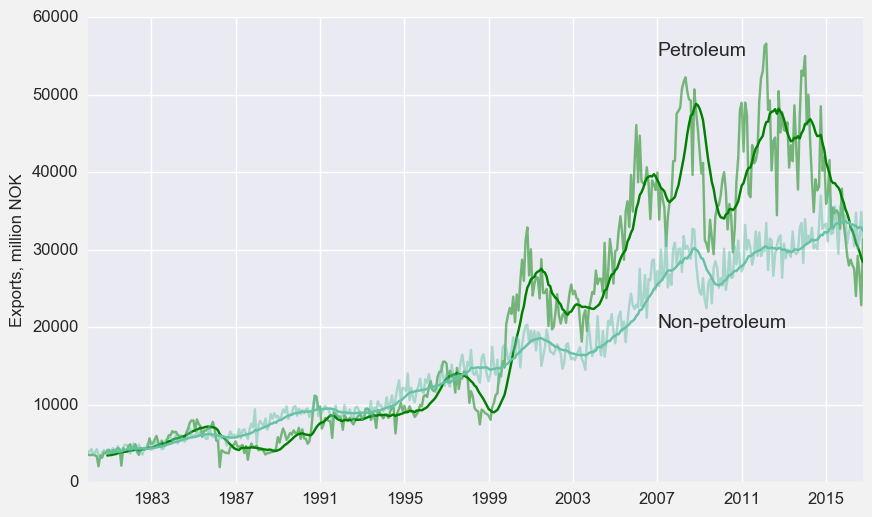

In [132]:
start = datetime.strptime('01012007', '%d%m%Y')

fig, ax = plt.subplots()
ax.plot()
ax.plot(eksport_w.date, eksport_w.petroleum_export, color="green", alpha=.5)
ax.plot(eksport_w.date, eksport_w.smooth_petroleum_export, color="green")
ax.plot(eksport_w.date, eksport_w.non_petroleum_export, color='#66c2a4', alpha=.5)
ax.plot(eksport_w.date, eksport_w.smooth_non_petroleum_export, color='#66c2a4')
ax.annotate('Petroleum', xy=(start, 55000))
ax.annotate('Non-petroleum', xy=(start, 20000))
ax.set_ylabel("Exports, million NOK")
fig.savefig("figures/exports_levels.png")
plt.show()

#### YoY pct change

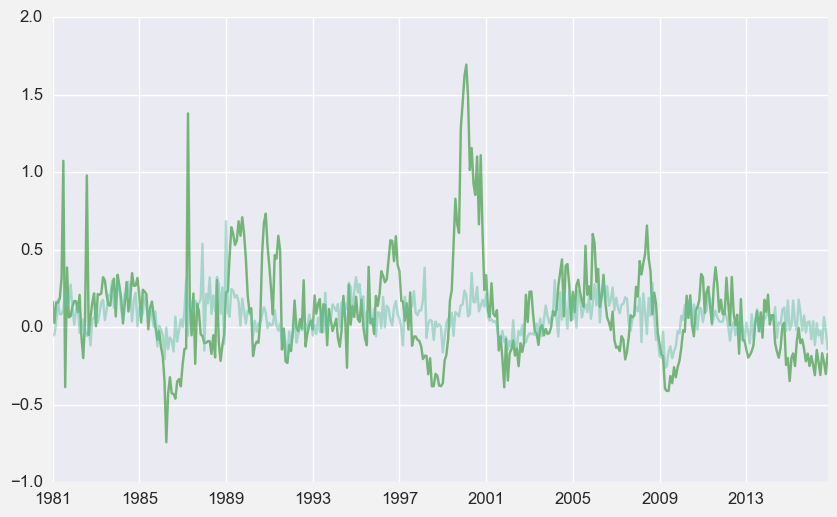

In [133]:
fig, ax = plt.subplots()
ax.plot()
ax.plot(eksport_w.date, eksport_w.perc_petroleum_export, color="green", alpha=.5)
#ax.plot(eksport_w.date, eksport_w.smooth_petroleum_export, color="green")
ax.plot(eksport_w.date, eksport_w.perc_non_petroleum_export, color='#66c2a4', alpha=.5)
#ax.plot(eksport_w.date, eksport_w.smooth_non_petroleum_export, color='#66c2a4')
#ax.annotate('Petroleum', xy=(start, 55000))
#ax.annotate('Non-petroleum', xy=(start, 20000))
#ax.set_ylabel("Exports, million NOK")
#fig.savefig("figures/exports_perc.png", bbox_inches='tight')
plt.show()

# Employment

In [134]:

employment_json = pd.read_json("https://data.ssb.no/api/v0/dataset/1054.json?lang=en")

age_labels = employment_json["dataset"]["dimension"]["Alder"]
sex_labels = employment_json["dataset"]["dimension"]["Kjonn"]
content_labels = employment_json["dataset"]["dimension"]["ContentsCode"]


In [135]:
employment = pd.read_csv("https://data.ssb.no/api/v0/dataset/1054.csv?lang=en")

employment.columns = ["sex", "age", "contents", "time", "value"]

unemp_1000 = employment[employment.contents == 'Unemployment (LFS) (1 000 persons), seasonally adjusted']
#unemp_1000 = unemp_1000[unemp_1000.sex=="0 Both sexes"]
unemp_1000 = unemp_1000[unemp_1000.age=="25-74 25-74 years"]
unemp_1000 = unemp_1000[["time", "sex", "value"]]

unemp_1000["time"] = unemp_1000.time.apply(lambda x:  x.replace("M", ""))
unemp_1000["time"] = pd.to_datetime(unemp_1000["time"], format="%Y%m")

unemp_1000["value"][unemp_1000.value == ".."] = np.nan
unemp_1000["value"] = unemp_1000.value.astype(float)

unemp_1000.columns =["date", "sex", "value"]
unemp_1000["sex"] = unemp_1000.sex.apply(lambda x: x[2:])


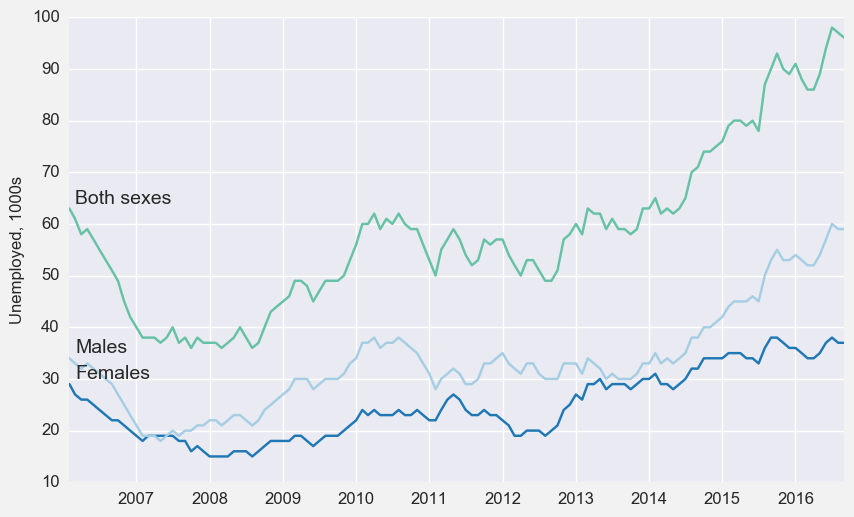

In [136]:
fig, ax = plt.subplots()
start = datetime.strptime('01032006', '%d%m%Y')
unemp_by_sex = unemp_1000.groupby("sex")
for unemp in unemp_by_sex:
	ax.plot(unemp[1].date, unemp[1].value, label=unemp[0])
	ax.annotate(unemp[0], xy=(start, np.array(unemp[1].value)[0]+1))
ax.set_ylabel("Unemployed, 1000s")
#ax.set_xlim(datetime.strptime('01012016', '%d%m%Y'))
fig.savefig("figures/unemployment.png")
plt.show()

In [137]:
emp_perc_sa = employment[employment.contents == "Employed persons in per cent of the population, seasonally adjusted"].copy()
emp_perc_sa.is_copy = False

emp_perc_sa = emp_perc_sa[emp_perc_sa.age=="25-74 25-74 years"]
emp_perc_sa = emp_perc_sa[["time", "sex", "value"]]

emp_perc_sa.loc[:,"time"] = emp_perc_sa.time.apply(lambda x:  x.replace("M", ""))
emp_perc_sa.loc[:,"time"] = pd.to_datetime(emp_perc_sa["time"], format="%Y%m")

emp_perc_sa.loc[:,"value"][emp_perc_sa.value == ".."] =np.nan
emp_perc_sa.loc[:,"value"] = emp_perc_sa.value.astype(float)

emp_perc_sa.columns =["date", "sex", "value"]
emp_perc_sa.loc[:,"sex"] = emp_perc_sa.sex.apply(lambda x: x[2:])

emp_perc_sa.set_index("date", inplace=True)
emp_perc_sa.reset_index(inplace=True)

start = datetime.strptime('01012008', '%d%m%Y')



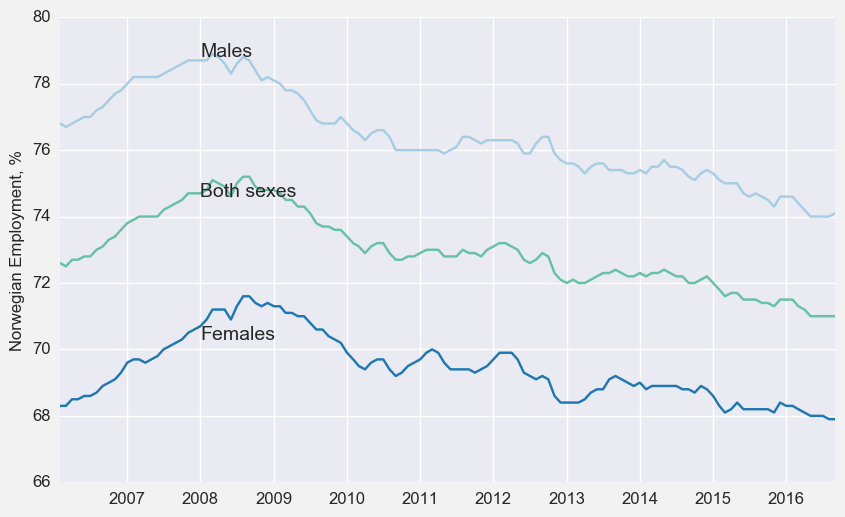

In [138]:
fig, ax = plt.subplots()
emp_by_sex = emp_perc_sa.groupby("sex")
for emp in emp_by_sex:
	ax.plot(emp[1].date, emp[1].value, label=emp[0])
	ax.annotate(emp[0], xy=(start, np.array(emp[1].value)[0]+2))
ax.set_ylabel("Norwegian Employment, %")
fig.savefig("figures/employment.png", bbox_inches='tight')
plt.show()

### Bankruptcies

In [139]:
bankruptcies = pd.read_csv("https://data.ssb.no/api/v0/dataset/95265.csv?lang=en")
enter_bank = bankruptcies[bankruptcies.contents == 'Bankruptcies related to enterprises (excl. sole propriertorships)']
pers_bank = bankruptcies[bankruptcies.contents == 'Personal bankruptcies (incl. sole propriertorships)']


In [140]:
enter_bank.tail()

,time,contents,"Bankruptcies, by time and contents"
1285,2016M06,Bankruptcies related to enterprises (excl. sol...,338
1290,2016M07,Bankruptcies related to enterprises (excl. sol...,168
1295,2016M08,Bankruptcies related to enterprises (excl. sol...,276
1300,2016M09,Bankruptcies related to enterprises (excl. sol...,269
1305,2016M10,Bankruptcies related to enterprises (excl. sol...,284


In [141]:
#enter_bank = enter_bank[enter_bank.iloc[:,2]!=".."]
#pers_bank = pers_bank[pers_bank.iloc[:,2]!=".."]

def format_df(df):
	df.columns = ["time", "contents", "value"]
	df = df[["time", "value"]]
	df.loc[:, "time"] = df.time.apply(lambda x:  x.replace("M", ""))
	df.loc[:, "time"] = pd.to_datetime(df["time"], format="%Y%m")
	#df.loc[:, "value"][df.value == ".."] =np.nan
	df.loc[:, "value"] = df.value.astype(float)
	return(df)

In [142]:
enter_bank.head()
enter_bank.tail()

,time,contents,"Bankruptcies, by time and contents"
1285,2016M06,Bankruptcies related to enterprises (excl. sol...,338
1290,2016M07,Bankruptcies related to enterprises (excl. sol...,168
1295,2016M08,Bankruptcies related to enterprises (excl. sol...,276
1300,2016M09,Bankruptcies related to enterprises (excl. sol...,269
1305,2016M10,Bankruptcies related to enterprises (excl. sol...,284


In [143]:


enter_bank = format_df(enter_bank)
pers_bank = format_df(pers_bank)

start = datetime.strptime('01012000', '%d%m%Y')




In [144]:
from scipy.interpolate import UnivariateSpline

enter_bank = enter_bank[enter_bank.value.notnull()]
pers_bank = pers_bank[pers_bank.value.notnull()]
t = len(enter_bank.time)
T = [i for i in range(t)]
s_enter = UnivariateSpline(T, enter_bank.value, k=3, s=400000)
smooth_enter = s_enter(T)

In [145]:


s_pers = UnivariateSpline(T, pers_bank.value, k=3, s=200000)
smooth_person = s_pers(T)

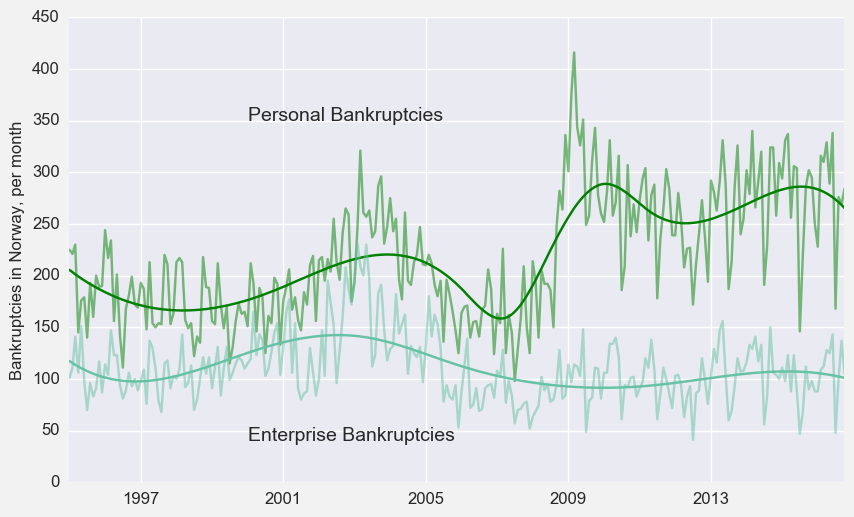

In [146]:
fig, ax = plt.subplots()
ax.plot(enter_bank.time, enter_bank.value, color="green", alpha=.5)
ax.plot(enter_bank.time, smooth_enter, color="green")
ax.plot(pers_bank.time, pers_bank.value, color='#66c2a4', alpha=.5)
ax.plot(pers_bank.time, smooth_person, color='#66c2a4')
ax.annotate('Personal Bankruptcies', xy=(start, 350))
ax.annotate('Enterprise Bankruptcies', xy=(start, 40))
ax.set_ylabel("Bankruptcies in Norway, per month")
fig.savefig("figures/bank_plot.png", bbox_inches='tight')
plt.show()

# Housing Prices

In [147]:
house_prices = pd.read_csv("https://data.ssb.no/api/v0/dataset/1060.csv?lang=no", sep=";", header=0)
house_prices.columns = ['region', 'type', 'time', 'variable','value']
time = house_prices.time.apply(lambda x: x.replace("K",""))
month = [str(int(t[-1])*3) for t in time]
year = [str(int(t[:-1])) for t in time]
house_prices["time"] = [x+y for x,y in zip(year, month)]
house_prices["time"] = pd.to_datetime(house_prices.time, format='%Y%m')
na_values = ["..", "."]
house_prices = house_prices[~house_prices.value.isin(na_values)]
house_prices["value"] = house_prices.value.apply(lambda x: float(x.replace(",", ".")))

all_houses = house_prices[house_prices.type=="00 Boliger i alt"]

start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
all_houses = all_houses[all_houses.time>=start]


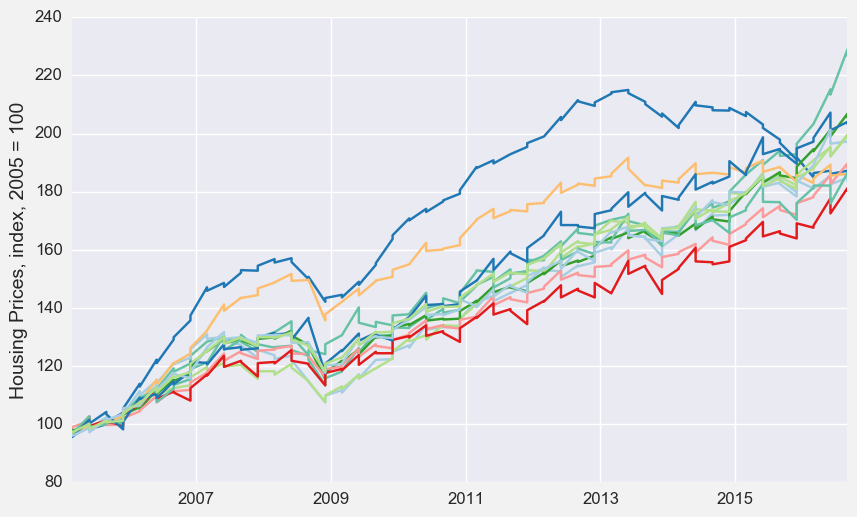

In [148]:
fig, ax = plt.subplots()
houses_by_region= all_houses.groupby("region")
for region in houses_by_region:
	ax.plot(region[1].time, region[1].value, label=region[0])
	#ax.legend()
	#n = len(region[1].value)
	#ax.annotate(region[0], xy=(end, region[1].value[0]) )
ax.set_ylabel("Housing Prices, index, 2005 = 100", size=14)
fig.savefig("figures/housing_prices.png", bbox_inches='tight')
plt.show()

In [149]:
names = []
prices_by_region = house_prices.groupby("region")
for region in prices_by_region:
	names.append(region[0])

new_names = ["Oslo with Baerum", "Stavanger", "Bergen", 
"Trondheim", "Akershus", "Southeast", "Hedmark and Oppland",
"Agder and Rogaland", "Westcoast", "Troendelag", "Northern Norway",
"Total"]

names_dict = dict(zip(names,new_names))

house_prices["region"] = house_prices.region.apply(lambda x: names_dict[x])

cities = new_names[0:4]

house_prices_cities = house_prices[house_prices.region.isin(cities)]
total_cities = house_prices_cities[house_prices_cities.type == "00 Boliger i alt"]
total_cities = total_cities[total_cities.variable == "Boligprisindeks, sesongjustert"]



In [150]:
start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
total_cities = total_cities[total_cities.time>=start]


In [151]:
total_cities.head()

,region,type,time,variable,value
897,Oslo with Baerum,00 Boliger i alt,2005-03-01,"Boligprisindeks, sesongjustert",97.5
899,Oslo with Baerum,00 Boliger i alt,2005-06-01,"Boligprisindeks, sesongjustert",98.0
901,Oslo with Baerum,00 Boliger i alt,2005-09-01,"Boligprisindeks, sesongjustert",100.3
903,Oslo with Baerum,00 Boliger i alt,2005-12-01,"Boligprisindeks, sesongjustert",104.3
905,Oslo with Baerum,00 Boliger i alt,2006-03-01,"Boligprisindeks, sesongjustert",107.7


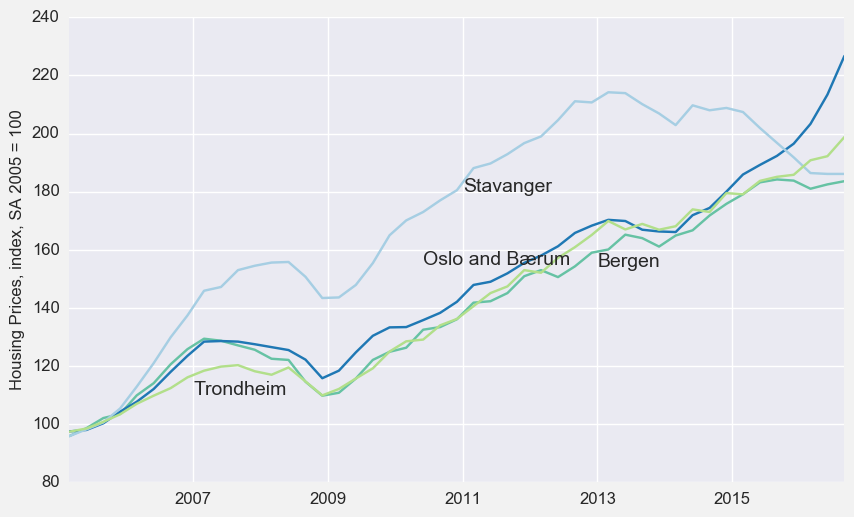

In [152]:
fig, ax = plt.subplots()
houses_by_city= total_cities.groupby("region")
for city in houses_by_city:
	ax.plot(city[1].time, city[1].value, label=city[0])
	#ax.legend()
	#n = len(region[1].value)
ax.annotate("Trondheim", xy=(datetime.strptime('01012007', '%d%m%Y'),110))
ax.annotate("Bergen", xy=(datetime.strptime('01012013', '%d%m%Y'),154))
ax.annotate("Stavanger", xy=(datetime.strptime('01012011', '%d%m%Y'),180))
ax.annotate("Oslo and Bærum", xy=(datetime.strptime('01062010', '%d%m%Y'),155))

ax.set_ylabel("Housing Prices, index, SA 2005 = 100")
fig.savefig("figures/city_housing_prices.png", bbox_inches='tight')
plt.show()

#### Long term housing costs

In [153]:
xls_housing = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/HousePrices.xlsx")
house_prices_l = xls_housing.parse('Table_A1', header=2)
house_prices_l.columns = ["year", "total", "oslo", "bergen", "trondheim", "kristiansand"]
house_prices_l = house_prices_l.iloc[15:,:]


In [154]:
house_prices_melt = pd.melt(house_prices_l, id_vars="year")
house_prices_melt["value"][house_prices_melt.value==" "] = np.nan
house_prices_melt["value"] =house_prices_melt.value.astype(float)


/Users/johannesmauritzen/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


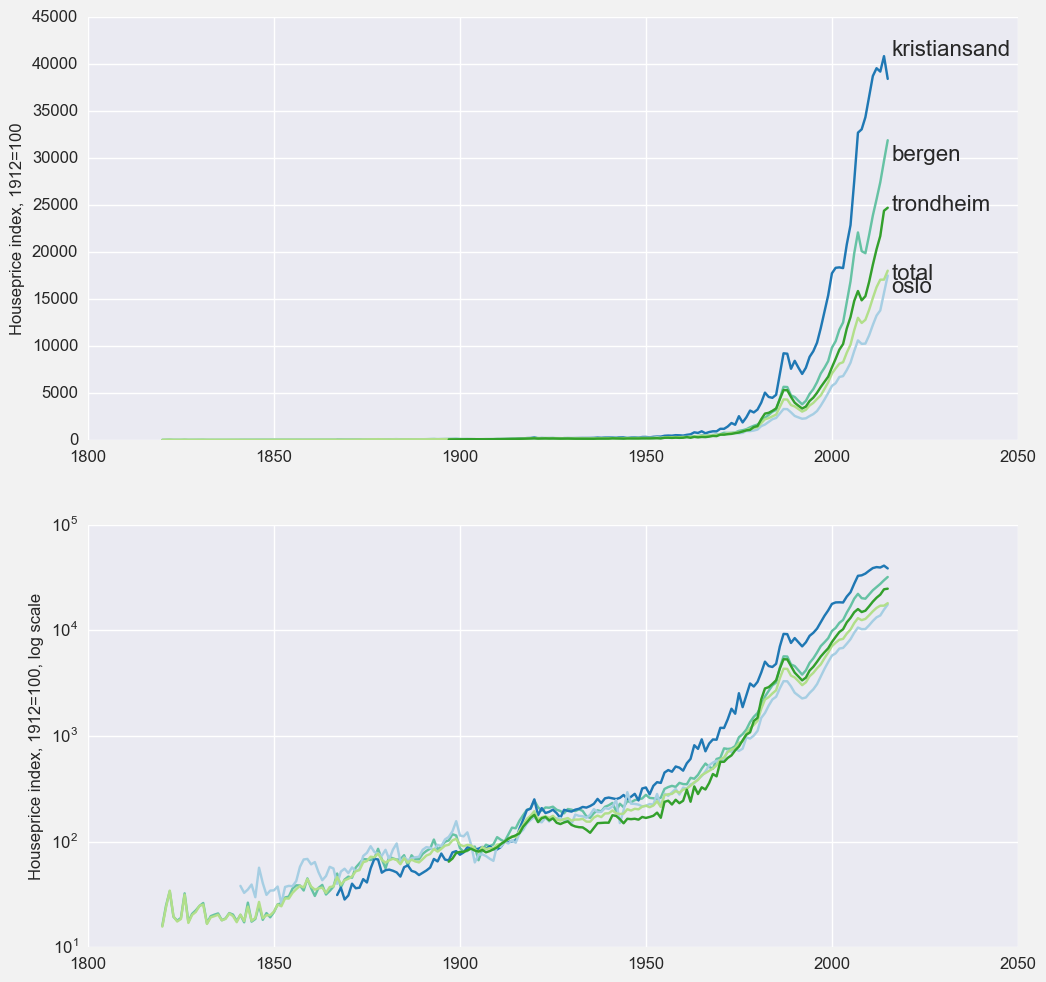

In [155]:
fig, ax = plt.subplots(2)
hp_by_city = house_prices_melt.groupby("variable")

for city_price in hp_by_city:
	ax[0].plot(city_price[1].year, city_price[1].value, label=city_price[0])
	ax[0].text(2016, np.array(city_price[1].value)[-2], city_price[0], size=16)
#ax.legend()
ax[0].set_ylabel("Houseprice index, 1912=100")

for city_price in hp_by_city:
	ax[1].plot(city_price[1].year, city_price[1].value, label=city_price[0])
ax[1].set_ylabel("Houseprice index, 1912=100, log scale")
ax[1].set_yscale('log')

fig.set_size_inches(12, 12)
fig.savefig("figures/houseprices_long.png")
plt.show()

### Housing Cost Index

In [156]:

cost_index = pd.read_csv("http://data.ssb.no/api/v0/dataset/26944.csv?lang=no", sep=";", decimal=",", na_values=["..", "."])
cost_index.columns = ['type', 'date', 'variable','index']
cost_index["date"] = pd.to_datetime(cost_index.date, format="%YM%m")

tot_cost_index = cost_index[cost_index.type=="01 I alt"]
del tot_cost_index["type"]

tot_cost_index_w = tot_cost_index.pivot(index="date", columns = "variable", values="index")
tot_cost_index_w.columns = ['cost index', '% change, mom',
       '% change, yoy']
tot_cost_index_w.reset_index(inplace=True)



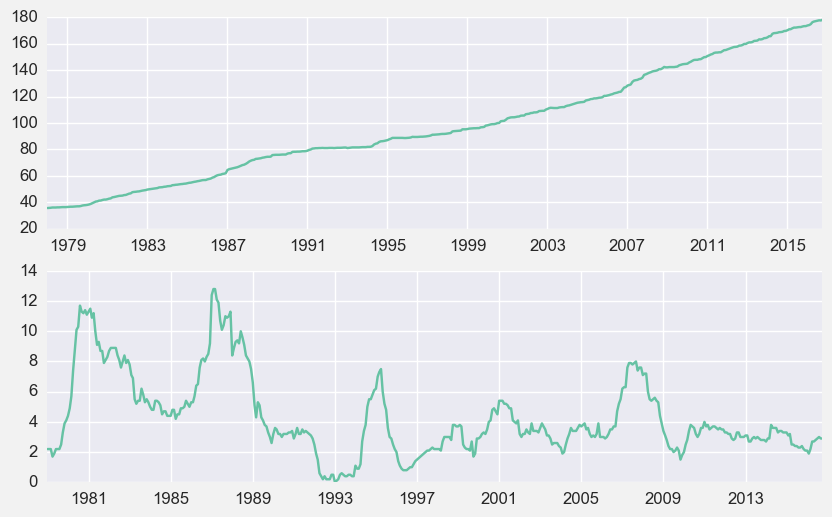

In [157]:
fig, ax = plt.subplots(2)
ax[0].plot(tot_cost_index_w.date, tot_cost_index_w["cost index"])
ax[1].plot(tot_cost_index_w.date, tot_cost_index_w["% change, yoy"])
plt.show()

In [158]:
tot_price_index = house_prices[house_prices.type == "00 Boliger i alt"]
tot_price_index = tot_price_index[tot_price_index.region =="Total"]
tot_price_index = tot_price_index[tot_price_index.variable == "Boligprisindeks, sesongjustert"]
#tot_price_index = tot_price_index[["time", "value"]]
#tot_price_index = tot_price_index.pivot(index="time", columns="region", values="value")


In [159]:
#tot_price_index.reset_index(inplace=True)


In [160]:

tot_price_index["% change, yoy"] = tot_price_index.value.pct_change(periods=4)*100
#tot_price_index.reset_index(inplace=True)
tot_price_index

,region,type,time,variable,value,"% change, yoy"
105,Total,00 Boliger i alt,2005-03-01,"Boligprisindeks, sesongjustert",97.1,NaN
107,Total,00 Boliger i alt,2005-06-01,"Boligprisindeks, sesongjustert",98.5,NaN
109,Total,00 Boliger i alt,2005-09-01,"Boligprisindeks, sesongjustert",100.7,NaN
111,Total,00 Boliger i alt,2005-12-01,"Boligprisindeks, sesongjustert",103.7,NaN
113,Total,00 Boliger i alt,2006-03-01,"Boligprisindeks, sesongjustert",107.1,10.298661
115,Total,00 Boliger i alt,2006-06-01,"Boligprisindeks, sesongjustert",110.9,12.588832
117,Total,00 Boliger i alt,2006-09-01,"Boligprisindeks, sesongjustert",116.1,15.292949
119,Total,00 Boliger i alt,2006-12-01,"Boligprisindeks, sesongjustert",120.8,16.489875
121,Total,00 Boliger i alt,2007-03-01,"Boligprisindeks, sesongjustert",125.0,16.713352
123,Total,00 Boliger i alt,2007-06-01,"Boligprisindeks, sesongjustert",127.7,15.148783


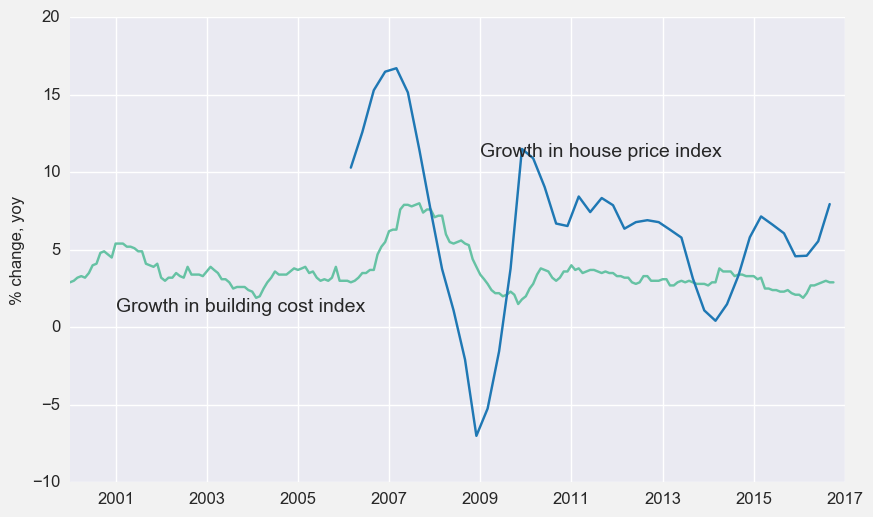

In [161]:

fig, ax = plt.subplots()
ax.plot(tot_cost_index_w.date, tot_cost_index_w["% change, yoy"])
ax.plot(tot_price_index.time, tot_price_index["% change, yoy"])
ax.set_xlim([pd.to_datetime("2000-01-01"), pd.to_datetime("2017-01-01")])
ax.set_ylabel("% change, yoy")
ax.annotate("Growth in house price index", xy=(datetime.strptime('01012009', '%d%m%Y'),11))
ax.annotate("Growth in building cost index", xy=(datetime.strptime('01012001', '%d%m%Y'),1))
fig.savefig("figures/building_cost.png")
plt.show()

### New housing starts, principalities with major cities

In [162]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/26025.csv?lang=no", sep=";", header=0, decimal=",")
bygging["region"]=bygging.region.astype('category')

fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland', 'Sogn og Fjordane',
       'Moere og Romsdal', 'Soer-Troendelag', 'Nord-Troendelag',
       'Nordland', 'Troms', 'Finnmark',
       'Svalbard']

bygging["region"] = bygging.region.cat.rename_categories(fylker)

bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m�)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)
bygging["tid"] = pd.to_datetime(bygging.tid, format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)


In [163]:
igangsatte = bygging[bygging.statistikkvariabel == "Igangsatte boliger"]
rel_fylker = ['Oslo', 'Rogaland', 'Hordaland',  'Soer-Troendelag']
igangsatte = igangsatte[bygging.region.isin(rel_fylker)]
igangsatte["region"] = igangsatte.region.astype('str')


/Users/johannesmauritzen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


#### Smoothing

In [164]:
from scipy.interpolate import UnivariateSpline

igangsatte = igangsatte[igangsatte.boligbygging.notnull()]

#bygging_by_city = igangsatte.groupby("region")
Oslo = igangsatte[igangsatte.region=="Oslo"]
Hordaland = igangsatte[igangsatte.region=="Hordaland"]
Rogaland = igangsatte[igangsatte.region =="Rogaland"]
Soer_Troendelag = igangsatte[igangsatte.region=="Soer-Troendelag"]

#smooth the city data
d = {"date":igangsatte["tid"][igangsatte.region=="Oslo"]}
smooth_data = pd.DataFrame(data=d)
t = len(Oslo.tid)
T = [i for i in range(t)]

s_city = UnivariateSpline(T, Oslo.boligbygging, k=3, s=6000000)
smooth_data["Oslo"] = s_city(T)

s_city = UnivariateSpline(T, Hordaland.boligbygging, k=3, s=2000000)
smooth_data["Hordaland"] = s_city(T)

s_city = UnivariateSpline(T, Rogaland.boligbygging, k=3, s=2000000)
smooth_data["Rogaland"] = s_city(T)

s_city = UnivariateSpline(T, Soer_Troendelag.boligbygging, k=3, s=2000000)
smooth_data["Soer-Troendelag"] = s_city(T)

smooth_data_l = pd.melt(smooth_data, id_vars = "date")

smooth_by_city = smooth_data_l.groupby("variable")


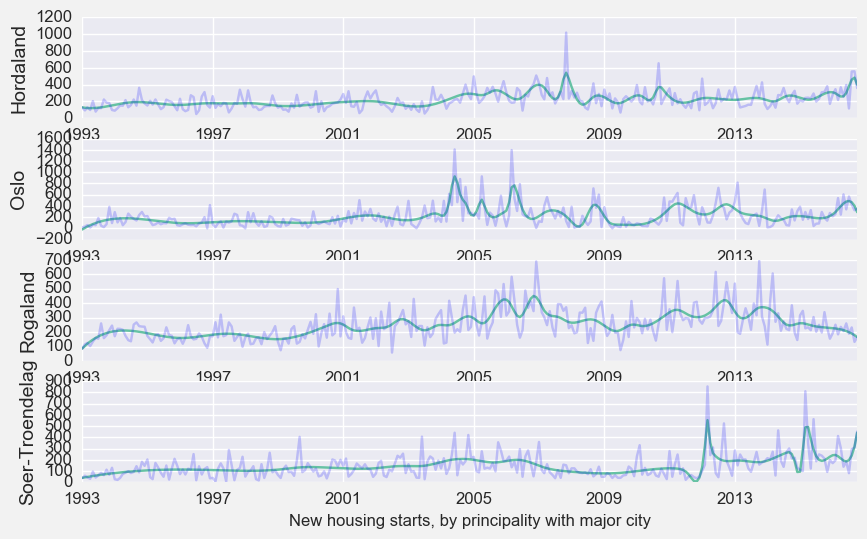

In [165]:
bygging_by_city = igangsatte.groupby("region")
fig, ax = plt.subplots(4)
for a, city in enumerate(smooth_by_city):
	ax[a].plot(city[1].date, city[1].value)
	ax[a].set_ylabel(city[0], size=14)

for a, city in enumerate(bygging_by_city):
	ax[a].plot(city[1].tid, city[1].boligbygging, alpha=.2, color="blue")
	#n = len(region[1].value)
#ax.set_ylabel("Number of new dwellings", size=14)
ax[3].set_xlabel("New housing starts, by principality with major city")
fig.savefig("figures/city_new_housing_starts.png")
plt.show()

### Entire Country

In [166]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/95146.csv?lang=no", sep=";", header=0, decimal=",")
bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m�)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)
bygging["tid"] = pd.to_datetime(bygging.tid, format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)

igangsatte = bygging[bygging.statistikkvariabel == "Igangsatte boliger"]
t = len(igangsatte.tid)
T = [i for i in range(t)]

s_igangsatte = UnivariateSpline(T, igangsatte.boligbygging, k=3, s=50000000)
smooth_igangsatte = s_igangsatte(T)


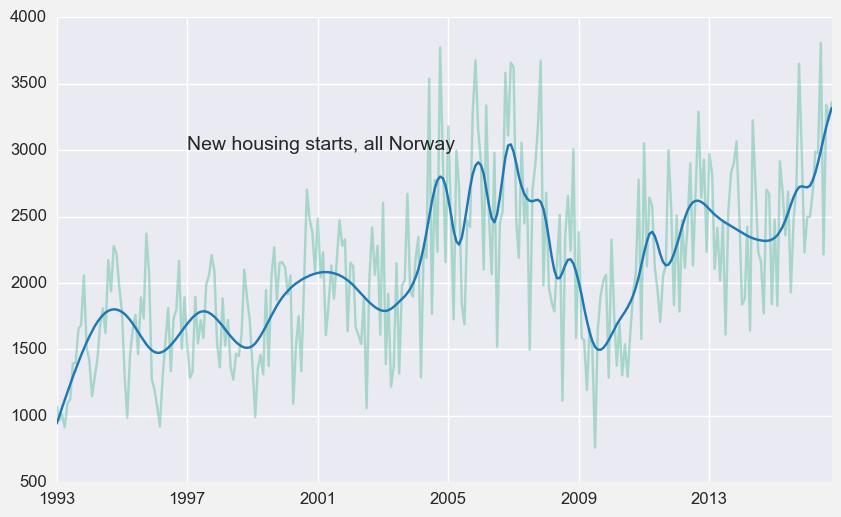

In [167]:
fig, ax = plt.subplots()
ax.plot(igangsatte.tid, igangsatte.boligbygging, alpha=.5)
ax.plot(igangsatte.tid, smooth_igangsatte)
ax.annotate("New housing starts, all Norway", xy=(datetime.strptime('01011997', '%d%m%Y'),3000))
fig.savefig("figures/new_housing_starts.png")
plt.show()

## Credit and Debt

In [168]:
#credit
debt_json = pd.read_json("https://data.ssb.no/api/v0/dataset/62264.json?lang=no")

debt = pd.read_csv("https://data.ssb.no/api/v0/dataset/62264.csv?lang=no", sep=";")
debt.columns = ['currency', 'sector', 'credit_source', 'time', 'variable','value']

debt["time"] = convert_datetime(debt.time)
debt["value"][debt.value == ".."] = np.nan
debt["value"] = debt.value.astype(float)
debt["value"] = debt["value"]/1000

by_source = debt.groupby("credit_source")
for source in by_source:
	print(source[0])

by_sector = debt.groupby("sector")
for sect in by_sector:
	print(sect[0])

total_sources = debt[debt.credit_source=="LTOT Kredittkilder i alt"]
total_sources = total_sources[total_sources.currency=="00 I alt"]




L201 Statlige l�neinstitutter
L202 Banker
L203 Kredittforetak
L204 Finansieringsselskaper
L206 Livsforsikringsselskaper
L207 Skadeforsikringsselskaper
L209 Pensjonskasser
L210 Obligasjonsgjeld
L211 Sertifikatgjeld
L212 Andre kilder
LTOT Kredittkilder i alt
Kred01 Publikum
Kred02 Kommuneforvaltningen
Kred03 Ikke-finansielle foretak
Kred04 Husholdninger mv.


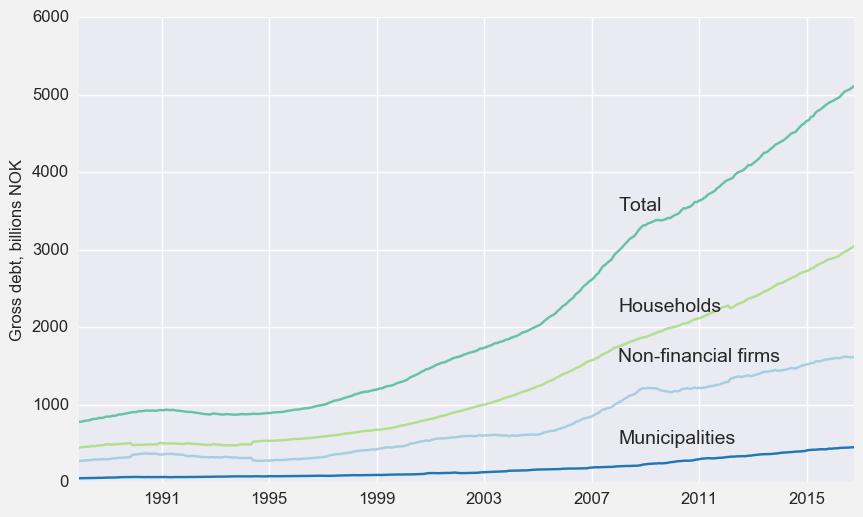

In [169]:
start = datetime.strptime('01012008', '%d%m%Y')
fig, ax = plt.subplots()
tot_by_sector = total_sources.groupby("sector")
for sect in tot_by_sector:
	ax.plot(sect[1].time, sect[1].value, label=sect[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("200801"),3500))
ax.annotate("Households", xy=(yearmonth("200801"), 2200))
ax.annotate("Non-financial firms", xy=(yearmonth("200801"), 1550))
ax.annotate("Municipalities", xy=(yearmonth("200801"), 500))
ax.set_ylabel("Gross debt, billions NOK")
fig.savefig("figures/debt_by_sector.png")
plt.show()


###   household debt by source

In [170]:
debt = debt[debt.value.notnull()]
debt = debt[debt.value!=0]

household = debt[debt.sector=="Kred04 Husholdninger mv."]
household = household[household.currency =="00 I alt"]

source_inc = ["L201 Statlige l�neinstitutter",
"L202 Banker",
"L203 Kredittforetak",
"LTOT Kredittkilder i alt"]

household = household[household.credit_source.isin(source_inc)]


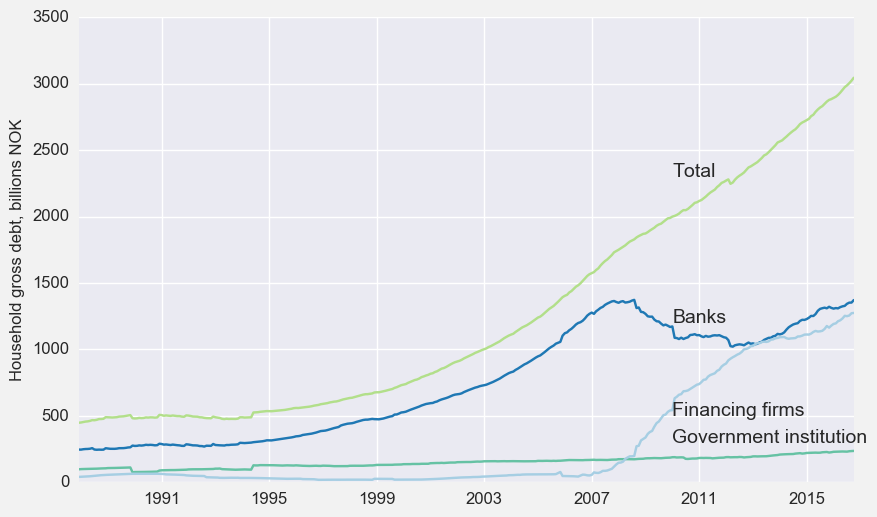

In [171]:
fig, ax = plt.subplots()
household_by_source = household.groupby("credit_source")
for source in household_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("201001"),2300))
ax.annotate("Banks", xy=(yearmonth("201001"), 1200))
ax.annotate("Financing firms", xy=(yearmonth("201001"), 500))
ax.annotate("Government institution", xy=(yearmonth("201001"), 300))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
fig.savefig("figures/household_debt_by_source.png")
plt.show()

#### by currency

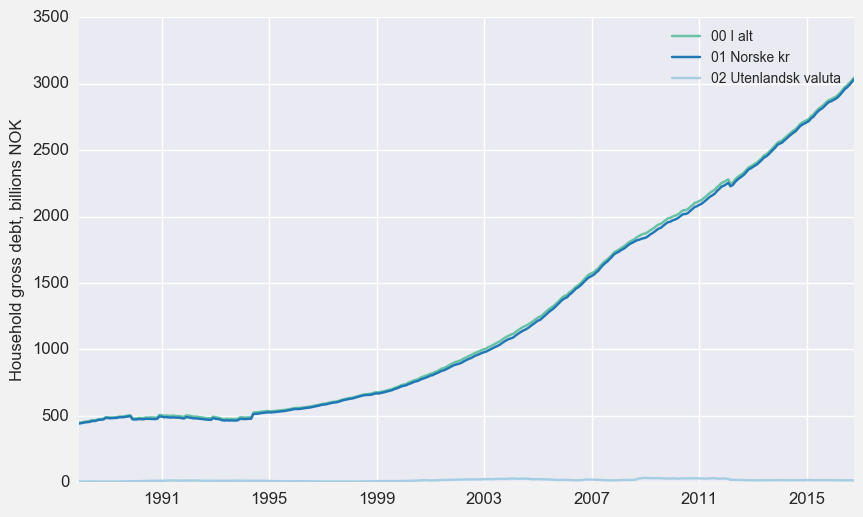

In [172]:
household = debt[debt.sector=="Kred04 Husholdninger mv."]
household = household[household.credit_source == "LTOT Kredittkilder i alt"]

fig, ax = plt.subplots()
household_by_currency = household.groupby("currency")
for currency in household_by_currency:
	ax.plot(currency[1].time, currency[1].value, label=currency[0])
ax.legend()
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
plt.show()

#### Non-financial firms

In [173]:
firms = debt[debt.sector=="Kred03 Ikke-finansielle foretak"]
firms = firms[firms.currency =="00 I alt"]

firms_inc = ["L201 Statlige l�neinstitutter",
"L202 Banker",
"L203 Kredittforetak",
"L204 Finansieringsselskaper",
"L206 Livsforsikringsselskaper",
"L207 Skadeforsikringsselskaper",
"L209 Pensjonskasser",
"L210 Obligasjonsgjeld",
"L211 Sertifikatgjeld",
"L212 Andre kilder",
"LTOT Kredittkilder i alt"]

#firms = firms[firms.credit_source.isin(source_inc)]



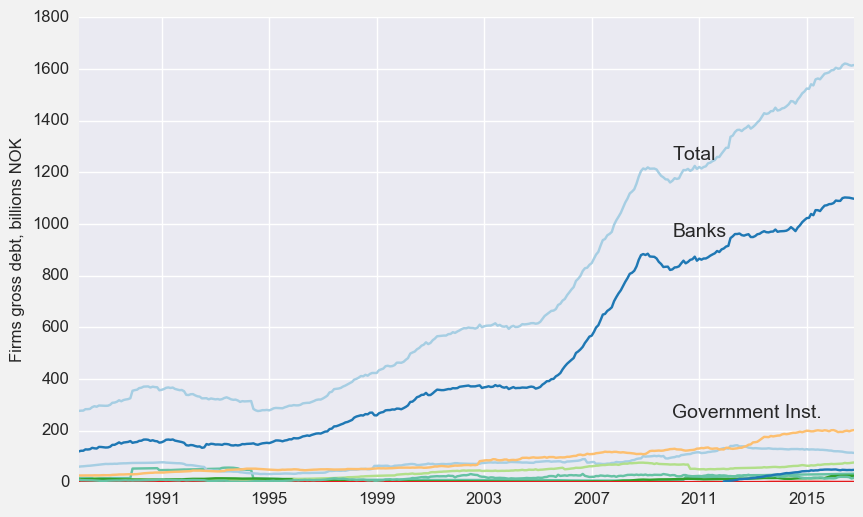

In [174]:
fig, ax = plt.subplots()
firms_by_source = firms.groupby("credit_source")
for source in firms_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("201001"),1250))
ax.annotate("Banks", xy=(yearmonth("201001"), 950))
ax.annotate("Government Inst.", xy=(yearmonth("201001"), 250))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Firms gross debt, billions NOK")
fig.savefig("figures/firm_debt_by_source.png")
plt.show()

#### Interest rates

In [175]:
ir=pd.read_csv("http://www.norges-bank.no/WebDAV/stat/en/renter/v2/renter_mnd.csv")

ir["DATES"] = [datetime.strptime(d, "%b-%y") for d in ir.DATES]

ir.columns = ['date', 'folio_nom', 'res_nom', 'dlaan_nom',
	   'statskvl_3m_eff','statskvl_6m_eff', 'statskvl_9m_eff', 
	   'statskvl_12m_eff','statsobl_3y_eff', 'statsobl_5y_eff', 
	   'statsobl_10y_eff', 'nowa_rt','nowa_vl']



include = ['date','dlaan_nom', 'statskvl_3m_eff', 'statskvl_12m_eff', 'statsobl_10y_eff']
ir = ir[include]



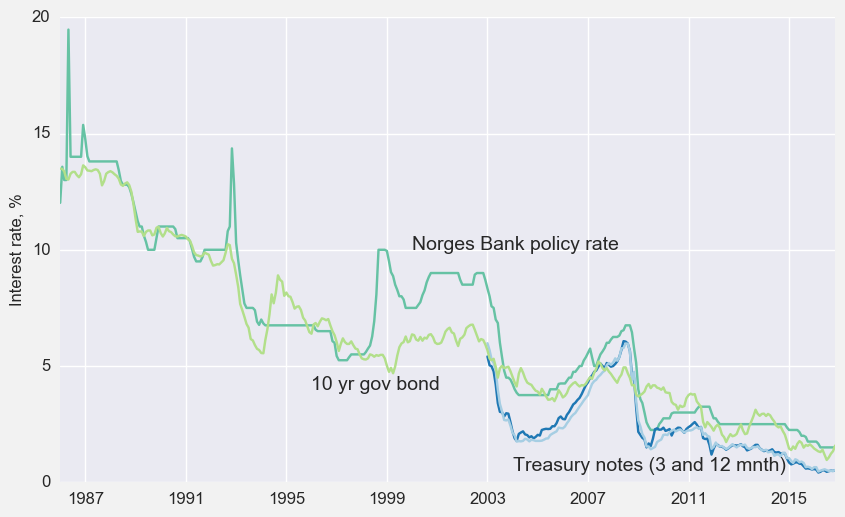

In [176]:
ir_long = pd.melt(ir, id_vars="date")
ir_long["value"][ir_long.value=="ND"] = np.nan
ir_long["value"] = ir_long.value.astype(float)

fig, ax = plt.subplots()
for r in ir_long.groupby("variable"):
	ax.plot(r[1].date, r[1].value, label=r[0])
ax.text(yearmonth("200001"), 10, "Norges Bank policy rate")
ax.text(yearmonth("200401"), .5, "Treasury notes (3 and 12 mnth)")
ax.text(yearmonth("199601"), 4, "10 yr gov bond")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/interest_rates.png")
plt.show()

#### Historical interest rates and inflation

In [177]:
long_ir = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/ShortTerm_IR.xlsx")
real_ir = long_ir.parse('p2c7_table_7B1',header=2)
real_ir = real_ir.iloc[:-13,:]
real_ir.Year = real_ir.Year.astype(float)

rir_include = ['Year', 'Real marginal rate', 'Real deposit rate', 'Real loans rate',
       'Real bond yield']

inflation_include = ['Year', 'Inflation rate', 'Smoothed inflation rate']

inflation = real_ir[inflation_include]
real_ir = real_ir[rir_include]



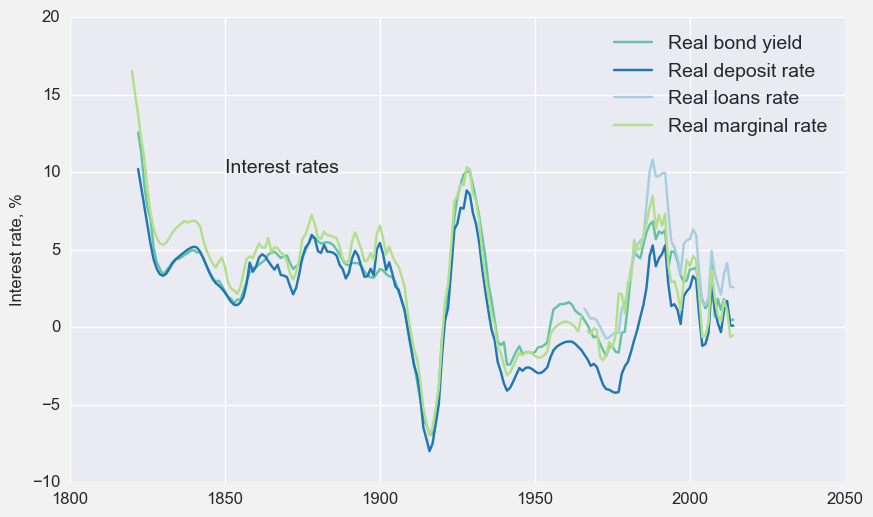

In [178]:
real_ir_long = pd.melt(real_ir, id_vars="Year")
fig, ax = plt.subplots()
for r in real_ir_long.groupby("variable"):
	ax.plot(r[1].Year, r[1].value, label=r[0])
ax.legend(fontsize=14)
ax.text(1850, 10, "Interest rates")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/ir_long.png")
plt.show()



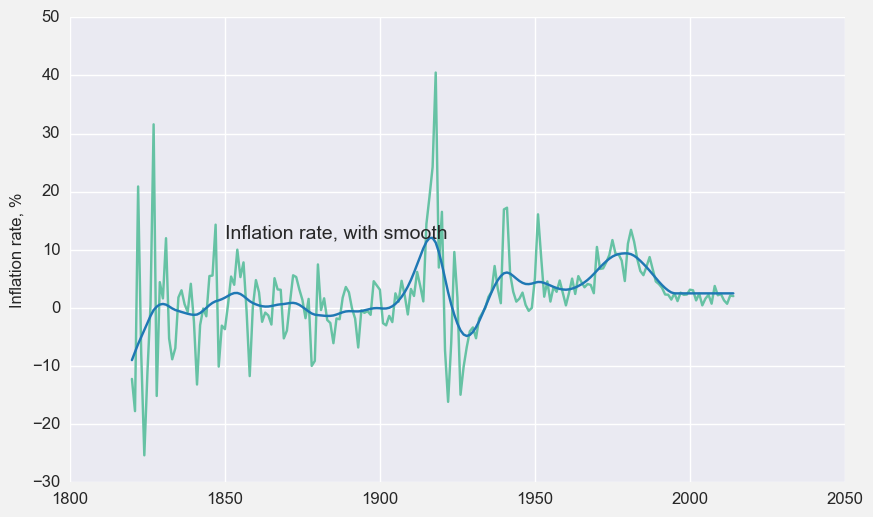

In [179]:
inflation_long = pd.melt(inflation, id_vars="Year")
fig, ax = plt.subplots()
for i in inflation_long.groupby("variable"):
	ax.plot(i[1].Year, i[1].value, label=i[0])
ax.text(1850, 12, "Inflation rate, with smooth")
ax.set_ylabel("Inflation rate, %")
# ax.legend()
fig.savefig("figures/long_inflation_rate")
plt.show()

## Oil and Gas

#### brent oil price


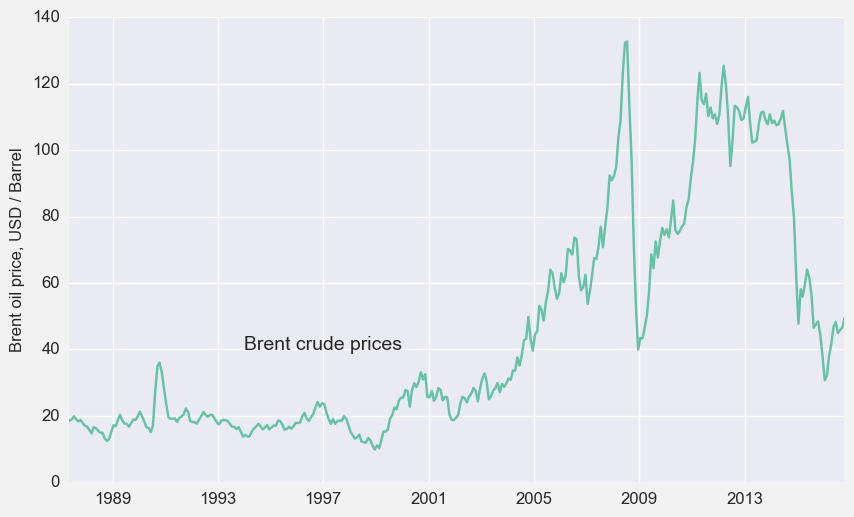

In [180]:
#prices from eia
xls = pd.ExcelFile("http://www.eia.gov/dnav/pet/hist_xls/RBRTEm.xls")
brent_prices = xls.parse('Data 1', header=2)

brent_prices.columns = ["date", "brent_price"]
brent_prices["date"] = pd.to_datetime(brent_prices.date, format="%Y-%m-%d")

fig, ax = plt.subplots()
ax.plot(brent_prices.date, brent_prices.brent_price, label="Brent Crude Price, $/Barrel")
ax.text(yearmonth("199401"), 40, "Brent crude prices")
#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Brent oil price, USD / Barrel")
fig.savefig("figures/brent_prices.png")
plt.show()

In [181]:
#prices from NPD
tot_prod=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_production_totalt_NCS_month__DisplayAllRows&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.56&CultureCode=nb-no")
tot_prod.columns = ['﻿prod_year', 'prod_month', 
'oil_millm3', 'gas_billsm3',
'ngl_millsm3', 'condensate_millsm3',
'oe_millsm3', 'water_millsm3']

tot_prod["date"] = pd.to_datetime(tot_prod.loc[:, '﻿prod_year'].astype(str) + tot_prod.loc[:,"prod_month"].astype(str),
	format = "%Y%m")

prod_include = ['date', 'oil_millm3', 'gas_billsm3','water_millsm3']
tot_prod = tot_prod[prod_include]

tot_prod_long = pd.melt(tot_prod, id_vars =["date"])
tot_prod_long["value"] = tot_prod_long.value.astype(float)
tot_prod_long = tot_prod_long[tot_prod_long.value!=0]

smoothed = tot_prod_long.groupby("variable")["value"].transform(smooth_series)
tot_prod_long["smoothed"] = smoothed


/Users/johannesmauritzen/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


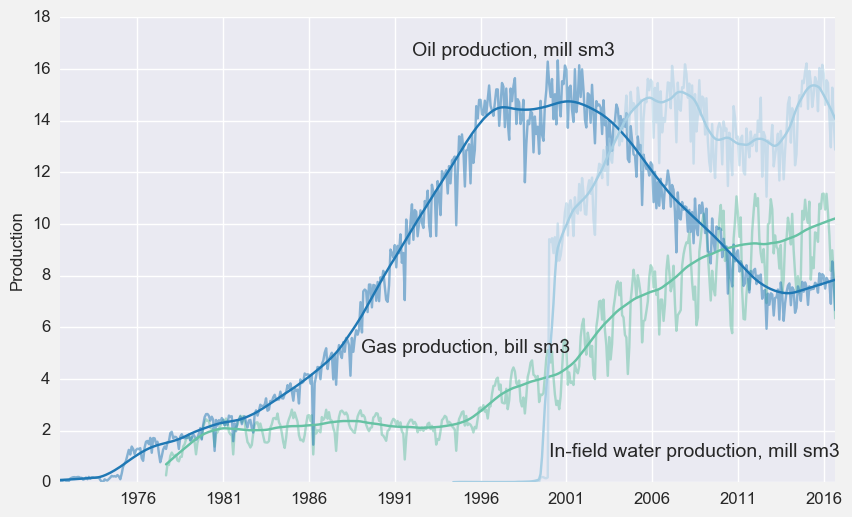

In [182]:
fig, ax = plt.subplots()
prod_by_liquid = tot_prod_long.groupby("variable")
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].value, label=liquid[0], alpha=.5)
plt.gca().set_color_cycle(None)
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].smoothed)
#ax.legend()
ax.text(yearmonth("199201"), 16.5, "Oil production, mill sm3")
ax.text(yearmonth("198901"), 5, "Gas production, bill sm3")
ax.text(yearmonth("200001"), 1, "In-field water production, mill sm3")
ax.set_ylabel("Production")
fig.savefig("figures/oil_gas_production.png")
plt.show()

#### Investment in oil and gas fields

In [183]:
investments=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_investment_yearly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.112&CultureCode=en")

tot_investments = investments.groupby("prfYear")['prfInvestmentsMillNOK'].aggregate(sum)
tot_investments = tot_investments.reset_index()
tot_investments.columns = ["year", "invest_millNOK"]
tot_investments = tot_investments[tot_investments.invest_millNOK!=0]




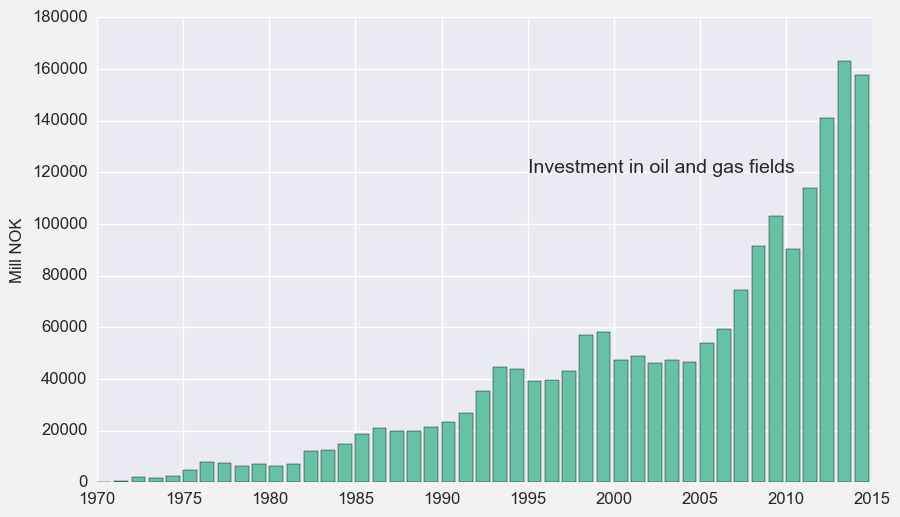

In [184]:
fig, ax = plt.subplots()
ax.bar(tot_investments.year, tot_investments.invest_millNOK, color="#66c2a4")
ax.set_ylabel("Mill NOK")
ax.text(1995, 120000, "Investment in oil and gas fields")
fig.savefig("figures/oil_investment.png", bbox_inches='tight')
plt.show()

# Wages and earnings

In [185]:
wages = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/Wages_Ind.xlsx")
tot_wages = wages.parse('Table_total', header=2)
ind_wages = wages.parse('Table_6A4', header=3)

#total wages
tot_wages = tot_wages.iloc[:-12,:]
tot_wages["Year"][tot_wages.Year=="2014*"] = "2014"
tot_wages["Year"] = tot_wages.Year.astype(int)

tot_wages_long = pd.melt(tot_wages, id_vars="Year")



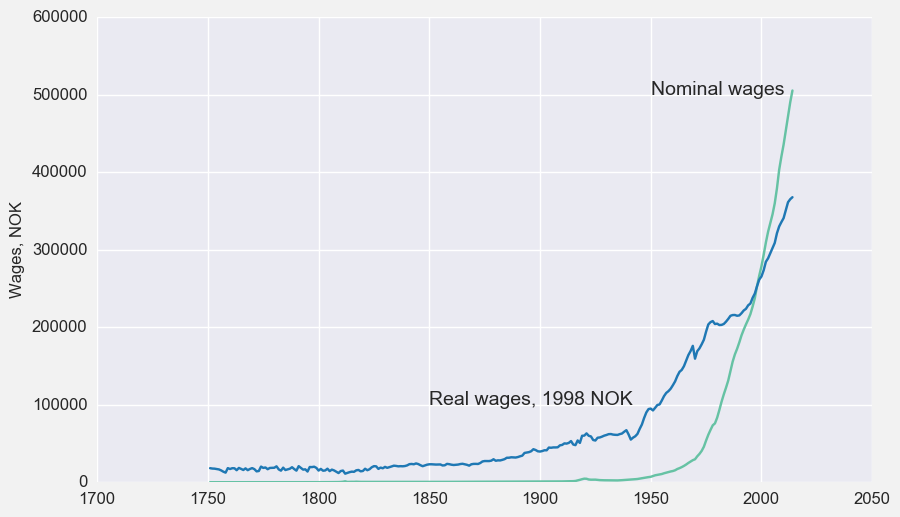

In [186]:
fig, ax = plt.subplots()
for wage in tot_wages_long.groupby("variable"):
	ax.plot(wage[1].Year, wage[1].value, label=wage[0])
ax.text(1850, 100000, "Real wages, 1998 NOK") 
ax.text(1950, 500000, "Nominal wages")
#ax.legend()
ax.set_ylabel("Wages, NOK")
fig.savefig("figures/tot_wages.png")
plt.show()

## Demographics

#### Population, by age grou

In [187]:
fm5aar=pd.read_csv("http://data.ssb.no/api/v0/dataset/65195.csv?lang=no", sep=";")
fm5aar.columns = ['alder', 'kjoenn', 'tid', 'statistikkvariabel',
       'personer']
fm5aar["alder"] = [i.split(" ")[1] for i in fm5aar.alder]




In [188]:
totalt = fm5aar[fm5aar.kjoenn == "0 Begge kj�nn"]

totalt_fm5 = totalt[["tid", "alder", "personer"]]
totalt_fm5_w = totalt_fm5.pivot(index='tid', columns='alder', values='personer')
totalt_fm5_w.columns.values
totalt_fm5_w = totalt_fm5_w[['0-4','5-9', '10-14','15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49',  '50-54', '55-59', '60-64', '65-69',
       '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100']]

Y = np.array(totalt_fm5_w)

dates = totalt_fm5.tid.unique()



In [189]:
fm5_2015 = totalt_fm5[totalt_fm5.tid==2015]
fm5_2015["annotate_y"] = fm5_2015.personer.cumsum()
fm5_2015["annotate_y"] = [i-100000 for i in fm5_2015.annotate_y]
fm5_2015.head()

marks = ['0-4',  '10-14',  '20-24',  '30-34', 
       '40-44',  '50-54', '60-64','70-74',
        '80-84',  '100']

fm5_2015 = fm5_2015[fm5_2015.alder.isin(marks)]
fm5_2015["annotate_y"].iloc[-1] = fm5_2015["annotate_y"].iloc[-1] + 120000

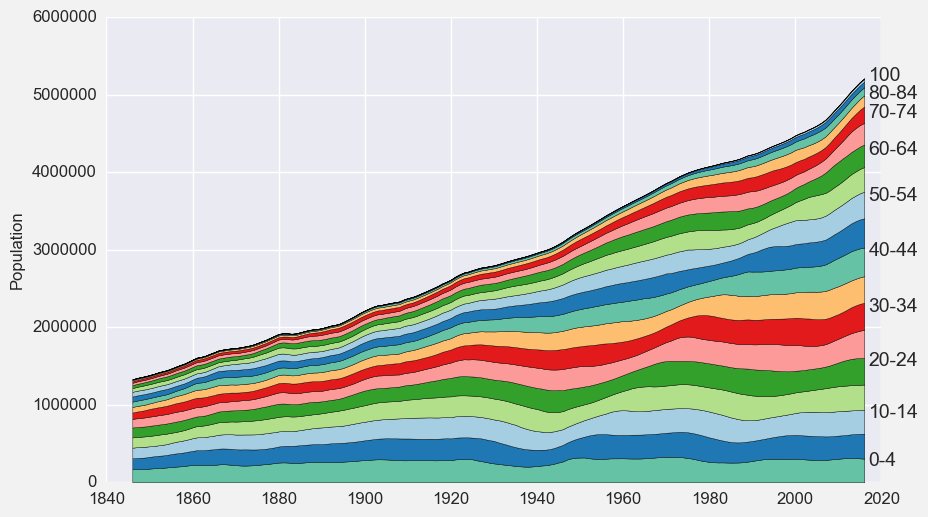

In [190]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for fm5 in fm5_2015.groupby("alder"):
    ax.annotate(fm5[0], xy=(2017, np.array(fm5[1].annotate_y)[0]))
ax.set_ylabel("Population")
fig.savefig("figures/pop_by_age.png")
plt.show()

#### Immigration

In [191]:
pop = pd.read_csv("http://data.ssb.no/api/v0/dataset/49626.csv?lang=no", sep=";")

pop.columns = ["region", "year", "variable", "value"]
pop = pop[["year", "variable", "value"]]
pop_tot = pop[pop.variable=="Folkemengde"]
pop_tot = pop_tot[["year", "value"]]
pop_tot.columns = ["year", "pop_tot"]

innvandring = pd.read_csv("http://data.ssb.no/api/v0/dataset/48651.csv?lang=no", sep=";")
innvandring.columns = ['region', 'kjoenn', 'landbakgrunn', 'year', 'statistikkvariabel',
       'innvandrer']
innvandring = innvandring[['kjoenn', 'landbakgrunn', 'year',
       'innvandrer']]
innvandring = innvandring.merge(pop_tot, on="year", how ="left")
innvandring["pros_innvan"] = innvandring["innvandrer"]/innvandring["pop_tot"]*100

total = innvandring.groupby(["year", "landbakgrunn"])["pros_innvan"].aggregate(sum)
total = total.reset_index()
total_w = total.pivot(index="year", columns="landbakgrunn", values="pros_innvan")
Y = np.array(total_w)
x=total.year.unique()

In [192]:
annotate_y = pd.DataFrame()
annotate_y["labels"] = ["Europe", "Africa", "Asia w Turkey", "North America", "South America", "Oseania"]
annotate_y["y"] = [6,8, 11, 12.5, 13, 13.5]

In [193]:
for ant in annotate_y.iterrows():
    print(ant[1]["labels"])

Europe
Africa
Asia w Turkey
North America
South America
Oseania


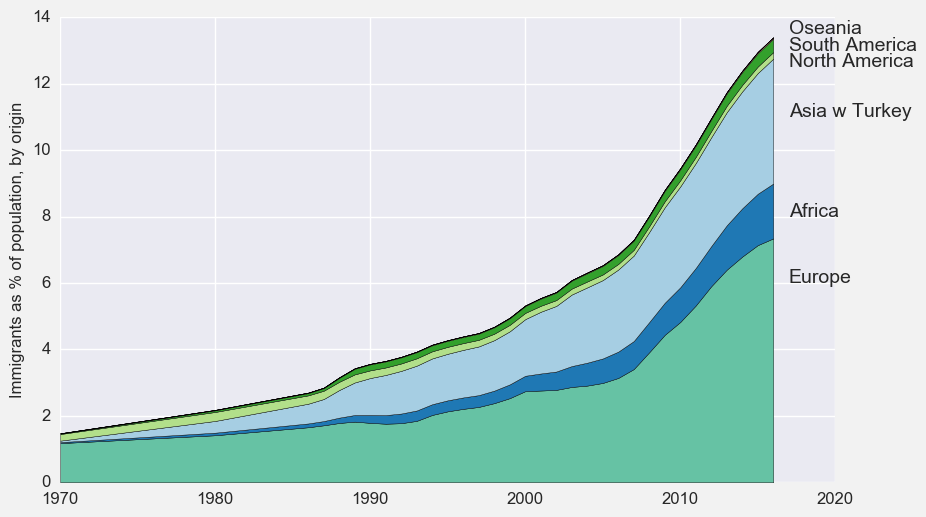

In [194]:

fig, ax = plt.subplots()
ax.stackplot(x, Y.T)
for ant in annotate_y.iterrows():
    ax.annotate(ant[1]["labels"], xy=(2017, ant[1]["y"]))
ax.set_ylabel("Immigrants as % of population, by origin")
fig.savefig("figures/imig_pros.png")
plt.show()

#### Migration to the cities

In [195]:
fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland',
       'Bergen', 'Sogn og Fjordane', 'Moere og Romsdal',
       'Sør-Trøndelag', 'Nord-Troendelag', 'Nordland',
       'Troms', 'Finnmark']


#Look at population
population = pd.read_csv("http://data.ssb.no/api/v0/dataset/49623.csv?lang=no", sep=";")
population["tid"] = pd.to_datetime(population.tid, format="%Y")

population.region = population.region.astype('category')

population["region"] = population.region.cat.rename_categories(fylker)
population = population[population.region.isin(['Oslo', 'Rogaland', 'Hordaland','Sør-Trøndelag'])]

population.columns = ["region", "tid", "statistikkvariabel", "population"]
population["population"] = population.population.astype(float)
population.region = population.region.astype(str)

innflyttinger = population[population.statistikkvariabel.isin(["Innflyttinger"])]
del innflyttinger["statistikkvariabel"]
innflyttinger.columns = ['region', 'tid', 'innflyttinger']
innflyttinger["utflyttinger"] = population.population[population.statistikkvariabel=="Utflyttinger"].values
innflyttinger["net_migration"] = innflyttinger["innflyttinger"] - innflyttinger["utflyttinger"]
folkemengde = population[population.statistikkvariabel=="Folkemengde"]


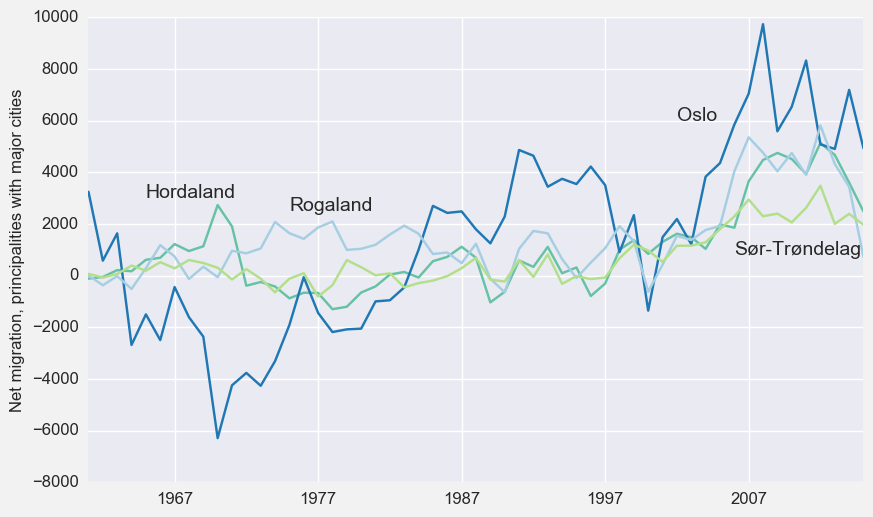

In [196]:

innflyttinger_by_city = innflyttinger.groupby("region")
fig, ax = plt.subplots()
for city in innflyttinger_by_city:
	ax.plot(city[1].tid.iloc[10:-1], city[1].net_migration.iloc[10:-1], label=city[0])
ax.text(pd.to_datetime(2002, format="%Y"), 6000, "Oslo")
ax.text(pd.to_datetime(1975, format="%Y"), 2500, "Rogaland")
ax.text(pd.to_datetime(2006, format="%Y"), 800, "Sør-Trøndelag")
ax.text(pd.to_datetime(1965, format="%Y"), 3000, "Hordaland")
ax.set_ylabel("Net migration, principalities with major cities")
fig.savefig("figures/net_migration_cities.png")
plt.show()



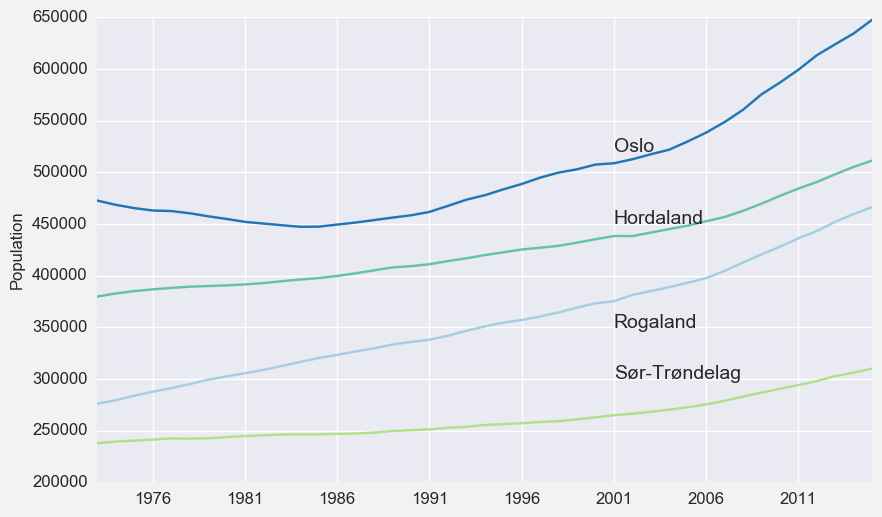

In [197]:
folkemengde_by_city = folkemengde.groupby("region")
fig, ax = plt.subplots()
for city in folkemengde_by_city:
	ax.plot(city[1].tid.iloc[22:-1], city[1].population.iloc[22:-1], label=city[0])
ax.text(pd.to_datetime(2001, format="%Y"), 520000, "Oslo")
ax.text(pd.to_datetime(2001, format="%Y"), 350000, "Rogaland")
ax.text(pd.to_datetime(2001, format="%Y"), 300000, "Sør-Trøndelag")
ax.text(pd.to_datetime(2001, format="%Y"), 450000, "Hordaland")
ax.set_ylabel("Population")
fig.savefig("figures/pop_cities.png")

plt.show()

In [198]:
folkemengde.head()

,region,tid,statistikkvariabel,population
660,Oslo,1951-01-01,Folkemengde,434365.0
665,Oslo,1952-01-01,Folkemengde,437184.0
670,Oslo,1953-01-01,Folkemengde,440674.0
675,Oslo,1954-01-01,Folkemengde,444041.0
680,Oslo,1955-01-01,Folkemengde,447064.0



#### Import and export

In [199]:
#laks_eksport = ("http://data.ssb.no/api/v0/dataset/1122?lang=no", sep=";")

## National Accounts

In [200]:
NR=pd.read_csv("http://data.ssb.no/api/v0/dataset/59022.csv", 
         sep=";", decimal=",", na_values = [".", ".."])
NR.columns = ["variabel", "kvartal", "enhet", "verdi"]

NR["kvartal"]  = convert_datetime(NR.kvartal) #fra zoo

#sesong justert
NRSA = NR[NR.enhet == "Faste 2014-priser, sesongjustert (mill. kr)"]

#enhet "Faste 2013-priser, sesongjustert (mill. kr)"
NRSA = NRSA[["variabel", "kvartal", "verdi"]]

#use tidyr to split
kateg = NRSA.variabel.str.split('.', n=1).str[0]
variabel = NRSA.variabel.str.split(' ', n=1).str[1]

NRSA["kateg"] = kateg
NRSA["variabel"] = variabel


In [201]:
NRSA.head()

,variabel,kvartal,verdi,kateg
1,Konsum i husholdninger og ideelle organisasjoner,2000-03-01,205440,koh
3,Konsum i husholdninger og ideelle organisasjoner,2000-06-01,208892,koh
5,Konsum i husholdninger og ideelle organisasjoner,2000-09-01,208886,koh
7,Konsum i husholdninger og ideelle organisasjoner,2000-12-01,207632,koh
9,Konsum i husholdninger og ideelle organisasjoner,2001-03-01,210089,koh


In [202]:
#investering

investering = NRSA[NRSA.kateg =="bif"]
del investering["kateg"]

# invest_stack.reset_index(inplace=True)

# invest_stack = pd.melt(invest_stack, id_vars = "kvartal")

investering.head()
invest_w = investering.pivot(index='kvartal', columns='variabel', values='verdi')

invest_var = ['Total Investment', 'Fixed Assets',
       'Mainland Norway',
       'Foreign Shipping',
       'Extraction',
       'Mainland Norway, excl public sector',
       'Housing',
       'Private Sector',
       'Public Sector',
       'Other services',
       'Other production',
       'Industry and Mining',
       'Extraction Services']

invest_w.columns = invest_var

invest_stack = invest_w[["Extraction", "Housing", "Public Sector", "Total Investment"]]
invest_stack["Other"] = invest_stack["Total Investment"] - invest_stack[["Extraction", "Housing", "Public Sector"]].sum(axis=1)

del invest_stack["Total Investment"]


In [203]:
invest_stack.columns.values

array(['Extraction', 'Housing', 'Public Sector', 'Other'], dtype=object)

In [204]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas Extraction', 'Housing', 'Public Sector', 'Other']
annotate["Y"] = [10000, 50000, 80000, 120000]

Y = np.array(invest_stack)

dates = investering.kvartal.unique()


annotate

,labels,Y
0,Oil and Gas Extraction,10000
1,Housing,50000
2,Public Sector,80000
3,Other,120000


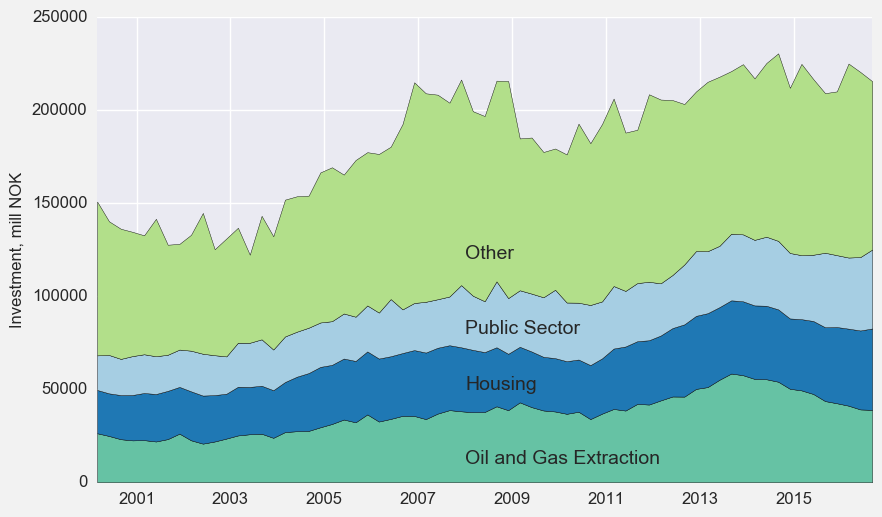

In [205]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
ax.set_ylabel("Investment, mill NOK")
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
fig.savefig("figures/na_investments.png")
plt.show()


### Eksport

In [206]:
eksport = NRSA[NRSA.kateg == "eks"]
del eksport["kateg"]
eksport_w = eksport.pivot(index='kvartal', columns='variabel', values='verdi')
eksport_w.columns =['Total', 'Oil and Gas',
       'Ships and Platforms', 'Services',
       'Traditional Commodities']
eksport_stack = eksport_w
del eksport_stack["Total"]


Y = np.array(eksport_stack)

dates = eksport_stack.index.values



In [207]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas', 'Ships and Platforms', 'Services', 'Other Commodities']
annotate["Y"] = [80000, 160000, 200000, 270000]


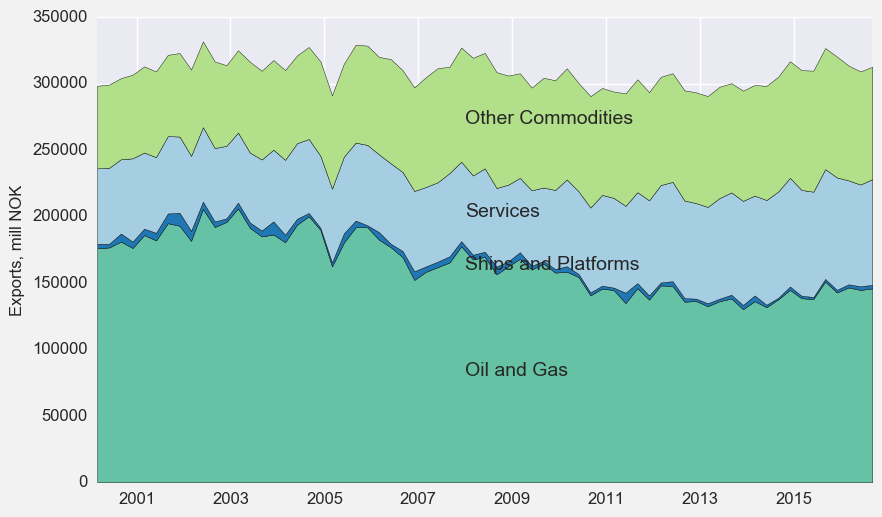

In [208]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Exports, mill NOK")
fig.savefig("figures/na_eksports.png")
plt.show()

### Imports 

In [209]:
imports =  NRSA[NRSA.kateg == "imp"]

del imports["kateg"]
imports_w = imports.pivot(index='kvartal', columns='variabel', values='verdi')
imports_w.columns =['Total', 'Oil and Gas',
       'Ships and Platforms', 'Services',
       'Other Goods']
       
imports_stack = imports_w
del imports_stack["Total"]


Y = np.array(imports_stack)

dates = imports_stack.index.values



In [210]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas',
       'Ships and Platforms', 'Services',
       'Other Goods']
annotate["Y"] = [5000, 17000, 50000, 150000]


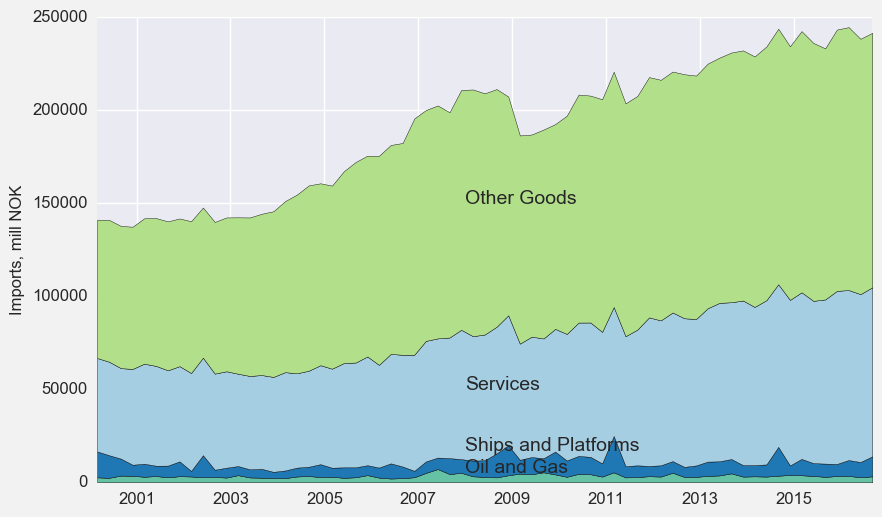

In [211]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Imports, mill NOK")
fig.savefig("figures/na_imports.png")
plt.show()

In [212]:
pkon = NRSA[NRSA.kateg=="koh"]

del pkon["kateg"]
pkon_w = pkon.pivot(index='kvartal', columns='variabel', values='verdi')
pkon_w.columns =['Household and Nonprofit',
       'Household', 'Household Foreign Consumption',
       'Services', 'Foreigners Consumption in Norway', 'Goods']

pkon_stack = pkon_w[['Services', 'Goods']]


Y = np.array(pkon_stack)

dates = pkon_stack.index.values



In [213]:
annotate = pd.DataFrame()
annotate["labels"] = ["Services", "Goods"]
annotate["Y"] = [50000, 150000]


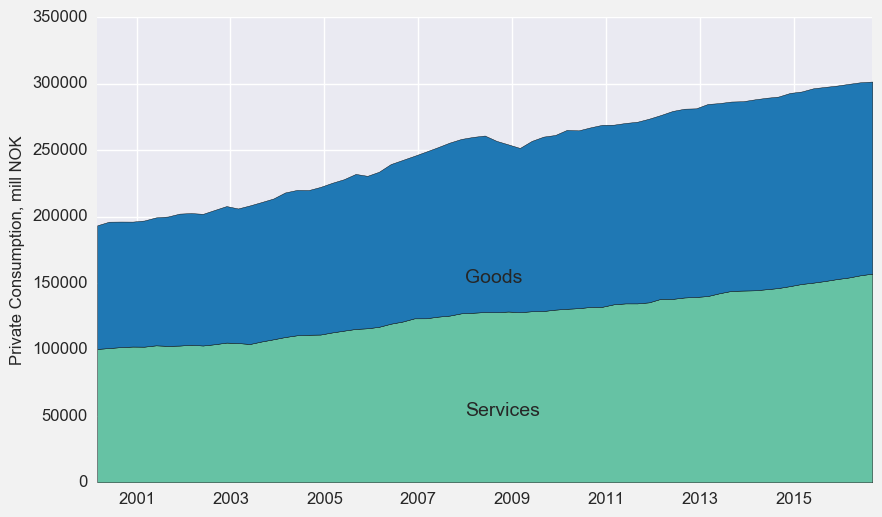

In [214]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Private Consumption, mill NOK")
fig.savefig("figures/na_privconsumption.png")
plt.show()

### Public sector 

In [215]:
okon = NRSA[NRSA.kateg=="koo"]

del okon["kateg"]
okon_w = okon.pivot(index='kvartal', columns='variabel', values='verdi')
okon_w.columns =['Public sector', 
	  'Principalities',
       'State',
       'State, Military',
       'State, Civil']

okon_stack = okon_w[['Principalities',
       'State, Military',
       'State, Civil']]

Y = np.array(okon_stack)

dates = okon_stack.index.values



In [216]:
annotate = pd.DataFrame()
annotate["labels"] = ['Principalities',
       'State, Military',
       'State, Civil']
annotate["Y"] = [40000, 90000, 120000]


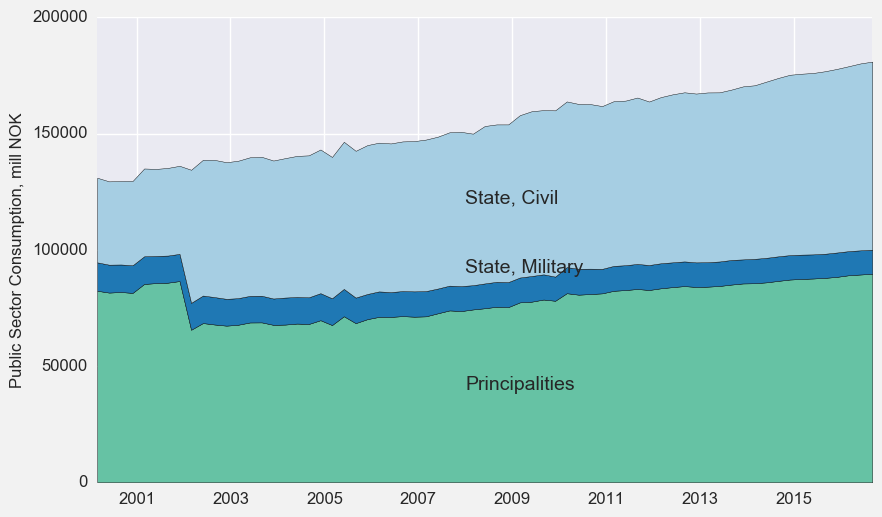

In [217]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Public Sector Consumption, mill NOK")
fig.savefig("figures/na_publicconsumption.png")
plt.show()

### As share of GDP

In [218]:
bnp = NRSA[NRSA.kateg == "bnpb"]
bnp = bnp[bnp.variabel=='Bruttonasjonalprodukt, markedsverdi']
bnp = bnp[["kvartal", "verdi"]]
bnp.columns = ["kvartal", "bnp"]

okon_stack.reset_index(inplace=True)
okon_perc = okon_stack.merge(bnp, how="left", on="kvartal")
okon_perc["State, Military, %GDP"] = okon_perc["State, Military"]/okon_perc["bnp"]*100
okon_perc["State, Civil, %GDP"] = okon_perc["State, Civil"]/okon_perc["bnp"]*100
okon_perc["Principalities, %GDP"] = okon_perc["Principalities"]/okon_perc["bnp"]*100
okon_perc = okon_perc[['kvartal', 'State, Military, %GDP', 'Principalities, %GDP',
       'State, Civil, %GDP']]

okon_l = pd.melt(okon_perc,id_vars="kvartal")



In [219]:
annotate2 = pd.DataFrame()
annotate2["labels"] = ['State, Military',
       'State, Civil',
       'Principalities']
annotate2["Y"] = [2, 8, 11]


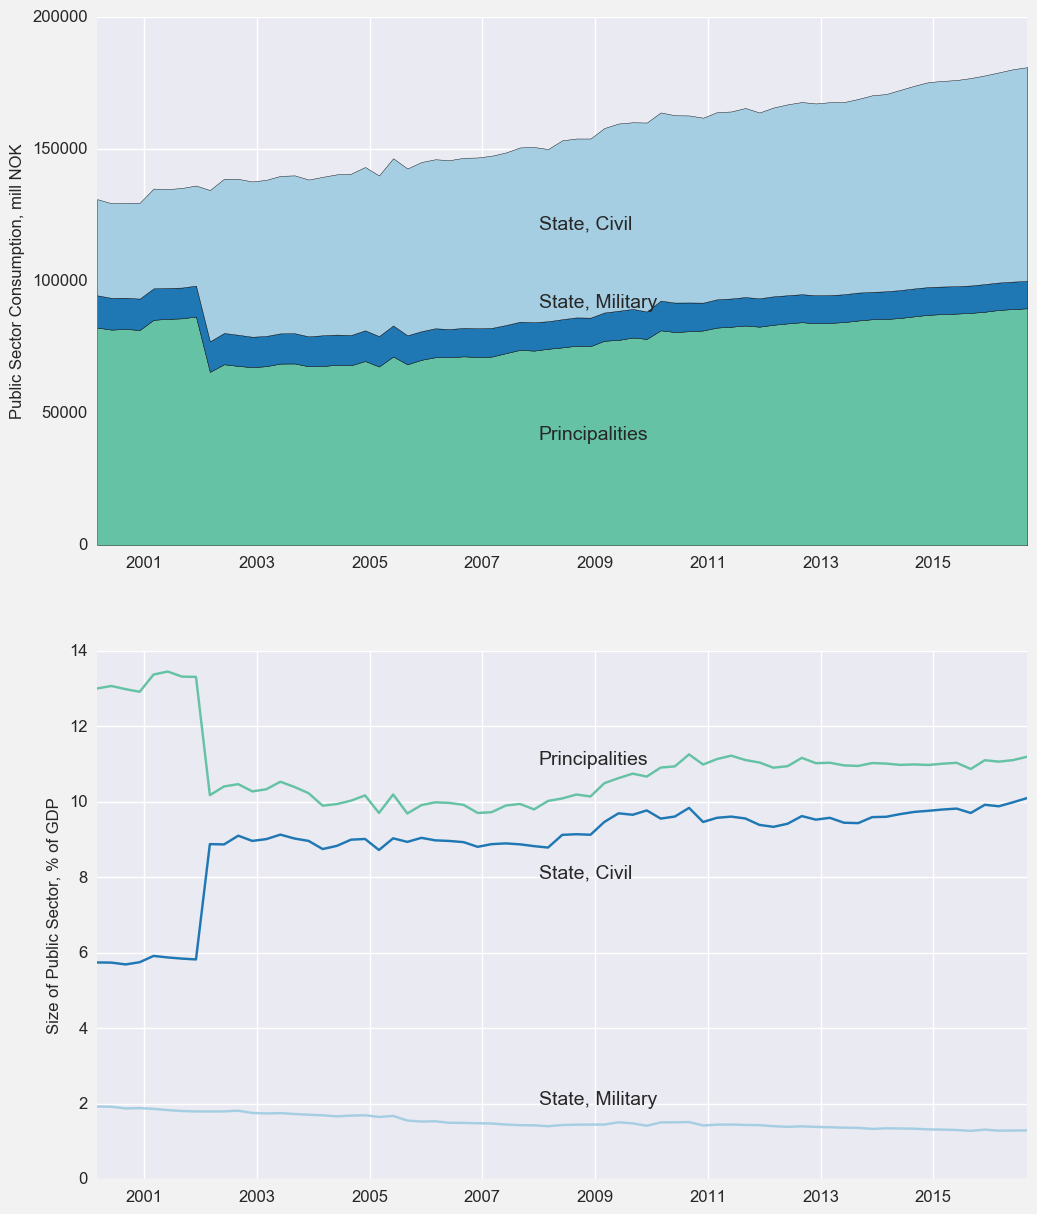

In [220]:
fig, ax = plt.subplots(2)
ax[0].stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax[0].annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax[0].set_ylabel("Public Sector Consumption, mill NOK")

start = datetime.strptime('01012008', '%d%m%Y')
okon_by_sector = okon_l.groupby("variable")
for sector in okon_by_sector:
	ax[1].plot(sector[1].kvartal, sector[1].value, label=sector[0])
ax[1].set_ylabel("Size of Public Sector, % of GDP")
for ant in annotate2.iterrows():
    ax[1].annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
fig.set_size_inches(12,15)
fig.savefig("figures/na_publicsector.png")
plt.show()

### Regionalt: Trondheim

#### house prices

In [221]:
trondheim_house_prices = total_cities.loc[total_cities.region == "Trondheim",]
trondheim_house_prices = trondheim_house_prices[["time", "value"]]
trondheim_house_prices.columns = ["date", "boligpriser"]

#percent change
trondheim_house_prices["perc_chang_priser"] = trondheim_house_prices.boligpriser.diff(periods=4)/trondheim_house_prices.boligpriser*100

trondheim_house_prices.head()


,date,boligpriser,perc_chang_priser
3273,2005-03-01,97.4,NaN
3275,2005-06-01,98.5,NaN
3277,2005-09-01,100.8,NaN
3279,2005-12-01,103.4,NaN
3281,2006-03-01,107.0,8.971963


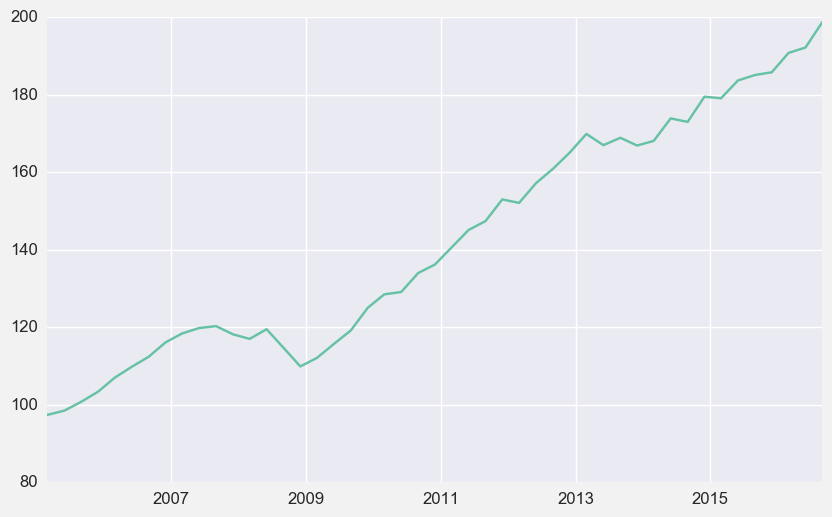

In [222]:
fig, ax = plt.subplots()
ax.plot(trondheim_house_prices.date, trondheim_house_prices.boligpriser)
plt.show()

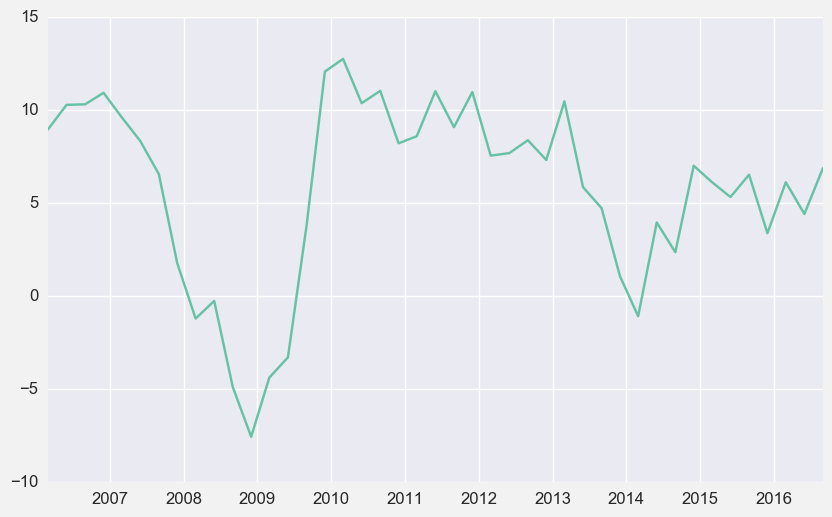

In [223]:
fig, ax = plt.subplots()
ax.plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
plt.show()

#### movement to trondheim

In [113]:
trond_innflytting = innflyttinger.loc[innflyttinger.region == "Sør-Trøndelag",]
trond_innflytting = trond_innflytting[["tid", "innflyttinger", "utflyttinger", "net_migration"]]
trond_innflytting.columns = ["date", "innflytting", "utflytting", "netto_migrasjon"]
trond_innflytting.head()

,date,innflytting,utflytting,netto_migrasjon
4953,1951-01-01,8946.0,9592.0,-646.0
4958,1952-01-01,8117.0,8981.0,-864.0
4963,1953-01-01,8868.0,9422.0,-554.0
4968,1954-01-01,9067.0,9305.0,-238.0
4973,1955-01-01,9560.0,10130.0,-570.0


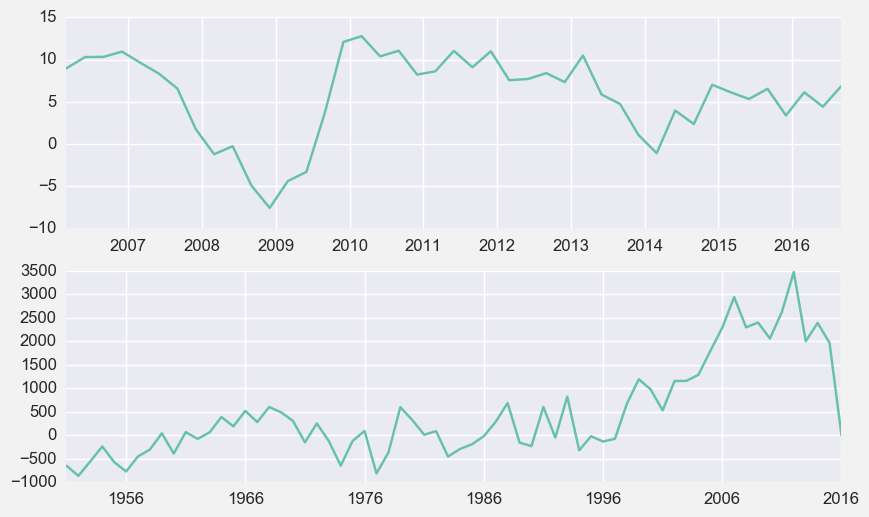

In [114]:
fig, ax = plt.subplots(2)
ax[0].plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
ax[1].plot(trond_innflytting.date, trond_innflytting.netto_migrasjon)
plt.show()

#### igangsatte

In [115]:
igangsatte.head()

,region,statistikkvariabel,tid,boligbygging
0,0 Hele landet,Igangsatte boliger,1993-01-01,1072.0
1,0 Hele landet,Igangsatte boliger,1993-02-01,967.0
2,0 Hele landet,Igangsatte boliger,1993-03-01,1011.0
3,0 Hele landet,Igangsatte boliger,1993-04-01,915.0
4,0 Hele landet,Igangsatte boliger,1993-05-01,1093.0


In [120]:
bygging.region.unique()

array(['0 Hele landet'], dtype=object)

In [122]:
bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
trond_fullforte = bygging.loc[bygging.statistikkvariabel == "Fullfoerte boliger", ]
trond_fullforte = trond_fullforte.loc[trond_fullforte.region == "Soer-Troendelag", ]
trond_fullforte = trond_fullforte[["tid", "boligbygging"]]
trond_fullforte.columns = ["date", "fullforte_bolig"]
trond_fullforte.head()


,date,fullforte_bolig


In [117]:

t = len(trond_fullforte.date)
T = [i for i in range(t)]

s_fullforte = UnivariateSpline(T, trond_fullforte.fullforte_bolig, k=3, s=2000000)
smooth_fullforte = s_fullforte(T)

error: (m>k) failed for hidden m: fpcurf0:m=0

NameError: name 'smooth_fullforte' is not defined

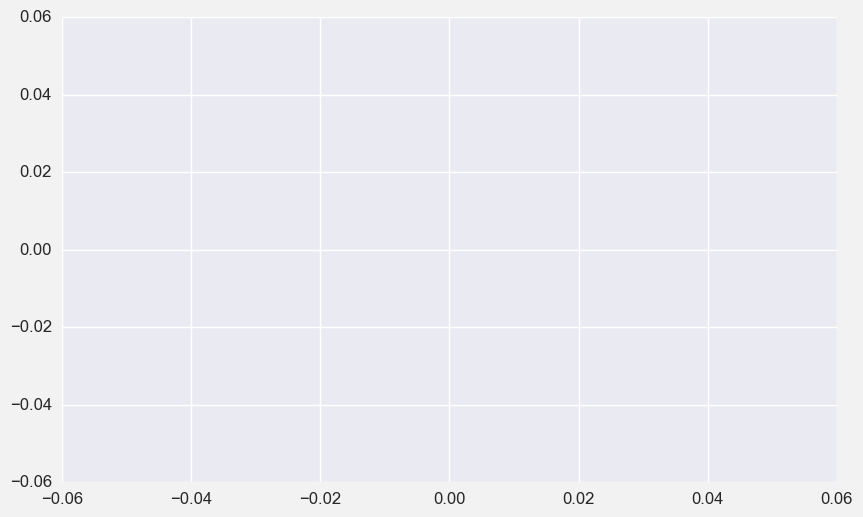

In [118]:
fig, ax = plt.subplots()
ax.plot(trond_fullforte.date, trond_fullforte.fullforte_bolig)
ax.plot(trond_fullforte.date, smooth_fullforte)
plt.show()

In [119]:
smooth_data.head()

,date,Oslo,Hordaland,Rogaland,Soer-Troendelag
3420,1993-01-01,-18.470089,129.605009,102.216619,38.910567
3421,1993-02-01,9.243139,125.240795,115.041186,43.408871
3422,1993-03-01,34.477584,122.693515,126.832755,47.738075
3423,1993-04-01,57.328079,121.791441,137.627560,51.900785
3424,1993-05-01,77.889457,122.362848,147.461839,55.899606


In [138]:
trondelag_smooth = smooth_data[["date", "Soer-Troendelag"]]
trondelag_smooth.columns = ["date", "igangsatte"]
trondelag_smooth.head()

,date,igangsatte
3420,1993-01-01,38.910567
3421,1993-02-01,43.408871
3422,1993-03-01,47.738075
3423,1993-04-01,51.900785
3424,1993-05-01,55.899606


In [122]:
troendelag_smooth.head()

3420    38.910567
3421    43.408871
3422    47.738075
3423    51.900785
3424    55.899606
Name: Soer-Troendelag, dtype: float64

In [130]:
ingangsatte_trondelag = Soer_Troendelag
ingangsatte_trondelag.head()

,region,statistikkvariabel,tid,boligbygging
23940,Soer-Troendelag,Igangsatte boliger,1993-01-01,36.0
23941,Soer-Troendelag,Igangsatte boliger,1993-02-01,58.0
23942,Soer-Troendelag,Igangsatte boliger,1993-03-01,43.0
23943,Soer-Troendelag,Igangsatte boliger,1993-04-01,31.0
23944,Soer-Troendelag,Igangsatte boliger,1993-05-01,95.0


In [208]:
ingangsatte_trondelag.tid.max()

Timestamp('2016-09-01 00:00:00')

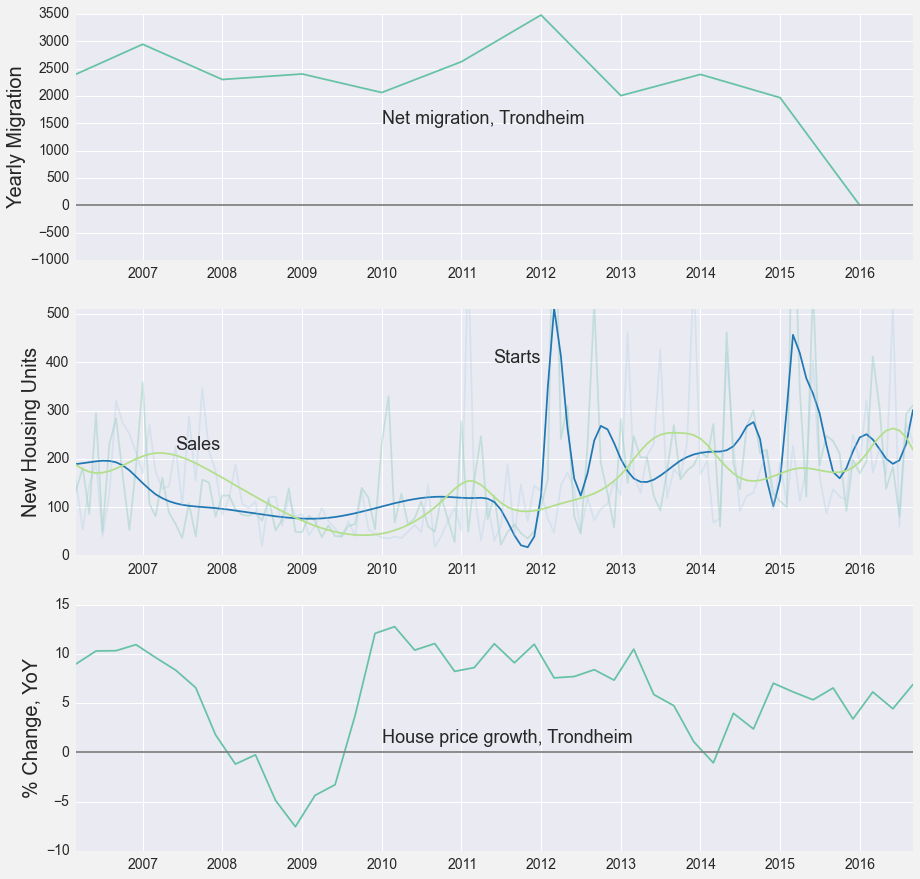

In [234]:
fig, ax = plt.subplots(3)
ax[0].plot(trond_innflytting.date, trond_innflytting.netto_migrasjon)
ax[0].set_xlim(pd.to_datetime("2006-03-01"), ingangsatte_trondelag.tid.max())
ax[0].axhline(color="grey")
ax[0].set_ylabel("Yearly Migration")
ax[0].text(yearmonth("201001"), 1500, "Net migration, Trondheim")
ax[1].plot(ingangsatte_trondelag.tid, 
           ingangsatte_trondelag.boligbygging, alpha=.3)
ax[1].plot(trondelag_smooth.date, 
           trondelag_smooth.igangsatte)
ax[1].plot(trond_fullforte.date, trond_fullforte.fullforte_bolig, alpha=.3)
ax[1].plot(trond_fullforte.date, smooth_fullforte)
ax[1].set_xlim(pd.to_datetime("2006-03-01"), ingangsatte_trondelag.tid.max())
ax[1].set_ylim(0, 510)
ax[1].set_ylabel("New Housing Units")
ax[1].text(yearmonth("201106"), 400, "Starts")
ax[1].text(yearmonth("200706"), 220, "Sales")

ax[2].plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
ax[2].set_ylabel("% Change, YoY")
ax[2].text(yearmonth("201001"), 1, "House price growth, Trondheim")
ax[2].axhline(color="grey")
fig.set_size_inches(15,15)
fig.savefig("figures/trondheim_housing_market.png")
plt.show()